# Analysis of Gliding Trajectories

The trajectories analyzed are single algae gliding on a flat glass surface. 

This notebooks works well for only one experiemntal condition at a time. For several conditions, the method of dictionnaries (see v5_analysis.ipynb for example) should be used instead. 

# Importations

In [64]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.optimize import curve_fit 
from scipy import stats
import scipy.signal
from scipy import signal
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind
import peakutils
import copy
from tqdm import tqdm
# Data management and plot
import seaborn as sns
import pandas as pd
import statannot # To create annotated boxplots, with several boxes, etc.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=600)

In [3]:
palette = sns.color_palette("coolwarm")
len(palette)

6

# Auxiliary functions

## Variables and files

In [4]:
# Convert a string of a variable name to the variable itself
def str2var(string):
    return globals()[string]

In [5]:
# Open .mat for holography experiments
def open_xyz_mat(pathname, upward=False, version='new'):
    data = loadmat(pathname, squeeze_me=True)
    if version == 'new':
        raw_data = np.zeros((len(data['x']), 3))
        raw_data[:,0] = data['x']
        raw_data[:,1] = data['y']
        raw_data[:,2] = data['z']
    elif version == 'old':
        raw_data = data["data"][:, 0:3]
    elif version == 'err':
        raw_data = np.zeros((len(data['x']), 7))
        raw_data[:,0] = data['x']
        raw_data[:,1] = data['y']
        raw_data[:,2] = data['z']
        raw_data[:,3] = data['dx']
        raw_data[:,4] = data['dy']
        raw_data[:,5] = data['dz']
        raw_data[:,6] = data['redchi']
    elif version == 'xyzrn':
        raw_data = np.zeros((len(data['x']), 5))
        raw_data[:,0] = data['x']
        raw_data[:,1] = data['y']
        raw_data[:,2] = data['z']
        raw_data[:,3] = data['a_p']
        raw_data[:,4] = data['n_p']
    else:
        print("Unknown version.")
        print("Try again.")
        # version = str(input("Data version?"))
        # raw_data = open_xyz_mat(pathname, upward=upward, version=version)
    if upward:
        raw_data[:,2] = - raw_data[:,2]
    del data
    return raw_data

In [6]:
def find_rn(filepath):
    """
    Find the radius of the particle in the file path. 
    The trajectory (.mat) should be in the last folder considered.
    """
    try:
        filename = filepath[filepath.rfind('/')+1:]
        r = float(filename[filename.find('_rp_')+4:filename.find('_np_')].replace('p','.')) * 1e-6
        n_p = float(filename[filename.find('_np_')+4:filename.find('_vid')].replace('p','.'))
    except:
        print(filepath)
        r = input("Enter the radius in um = ")
        r = float(r) * 1e-6
        n_p = input("Enter the refractive index = ")
        n_p = float(n_p)
    return r, n_p

In [7]:
def remove_end_zeros(data):
    try:
        ind = list(data[:,0]).index(0)
        data = data[:ind,:]
    except ValueError:
        print('No pb. No zero in raw data.')
    return data

In [8]:
def unpack_data(data, full=False):
    if full:
        x, y, z = data[:,0], data[:,1], data[:,2]
        dx, dy, dz = data[:,3], data[:,4], data[:,5]
        redchi = data[:,6]
        return x, y, z, dx, dy, dz, redchi
    else:
        x, y, z = data[:,0], data[:,1], data[:,2]
        return x, y, z

## Analyze data

In [9]:
def movmin(datas, k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k / 2))

    for i in range(len(datas)):
        if i < int(np.ceil(k / 2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k / 2)):
            end_pt = len(datas)
        result[i] = np.nanmin(datas[start_pt:end_pt])
        start_pt += 1
        end_pt += 1

    return result

In [10]:
def xy2r(x, y):
    return np.sqrt((x - x[0]) ** 2 + (y - y[0]) ** 2)

In [11]:
def moment(n, x, t, return_std = False, retrieve_mean = False, mean_abs = False):
    """
    Parameters
    ----------
    n: int, moment of order n
    x: array containing the values of interest
    t: an array containing differences of indexes.
    """
    res = np.zeros(len(t))
    std = np.zeros(len(t))
    for i, j in enumerate(t):
        #x_tau = x[j:] - np.mean(x[j:])
        #x_zer = x[0:-j] - np.mean(x[0:-j])
        #res[i] = np.nanmean((x_tau - x_zer)**n)
        Delta_x = x[j:] - x[0:-j]
        if retrieve_mean:
            distribution = (Delta_x - np.nanmean(Delta_x)) ** n
        else:
            distribution = (Delta_x) ** n
        if mean_abs:
            distribution = np.abs(distribution)
        res[i] = np.nanmean(distribution)
        std[i] = np.nanstd(distribution)
    if return_std:
        return res, std
    else:
        return res

In [12]:
def pdf(data, bins=10, density=True, range=None):
    pdf, bins_edge = np.histogram(
        data, 
        bins=bins, 
        density=density, 
        range=range, 
    )
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    return pdf, bins_center

# Load the data

## Define paths and prepare the loading

We load every experiments that is considered good (holograms that are symmetric and circular) from the experiment point of view.

In [13]:
# Datas must be given in SI

# Load the .mat files and convert them into np.ndarrays
# Via the aux function open_xyz_mat

# Datas are stored in a arrays: xxx, yyy, zzz, etc.

In [14]:
# First experimental condition
# Chlamys under blue light for a while then recording 

dirs = [
    './data/20240702/2/tracking_saving_everything/traj_rp_4p1575_np_1p398_vid_tracking_saving_everything_all.mat', 
    './data/20240710/6/traj_rp_3p7589_np_1p4043_vid_6.mat', 
    './data/20240711/1_trim/traj_rp_3p0426_np_1p3913_vid_1_trim.mat', 
    './data/20240712/2_trim/traj_rp_3p2102_np_1p4051_vid_2_trim.mat',
    # './data/20240712/3/traj_rp_4p4067_np_1p3955_vid_3.mat', 
    './data/20240712/4/traj_rp_4p9586_np_1p3926_vid_4.mat',
    './data/20240716/3/traj_rp_4p2123_np_1p3969_vid_3.mat',
    './data/20240716/4/traj_rp_4p199_np_1p401_vid_4.mat', 
    './data/20240716/5/traj_rp_3p7412_np_1p4022_vid_5.mat', 
    './data/20240717/2/traj_rp_3p3411_np_1p3994_vid_2.mat', 
    './data/20240717/3/traj_rp_2p9238_np_1p3951_vid_3.mat', 
    './data/20240717/4/traj_rp_3p4785_np_1p3977_vid_4.mat', 
    './data/20240718/1/traj_rp_3p6178_np_1p3985_vid_1.mat', 
    './data/20240718/2/traj_rp_3p6679_np_1p4_vid_2.mat', 
    './data/20240718/4/traj_rp_3p5684_np_1p4021_vid_4.mat', 
    './data/20240719/1/traj_rp_3p0909_np_1p4147_vid_1.mat', 
    './data/20240719/2/traj_rp_3p1909_np_1p4037_vid_2.mat', 
    './data/20240719/3/traj_rp_3p3515_np_1p4106_vid_3.mat', 
    './data/20240719/4/traj_rp_2p7599_np_1p4309_vid_4.mat', 
    './data/20240723/2/traj_rp_3p1505_np_1p4031_vid_2.mat', 
    './data/20240723/2_trim/traj_rp_3p2447_np_1p3992_vid_2_trim.mat', 
    './data/20240723/4/traj_rp_2p8087_np_1p4049_vid_4.mat', 
    './data/20240723/4_trim/traj_rp_2p7824_np_1p4012_vid_4_trim.mat', 
    './data/20240723/5/traj_rp_3p6434_np_1p4003_vid_5.mat', 
    './data/20240723/6/traj_rp_3p4715_np_1p3986_vid_6.mat', 
]

fpss = [50] * len(dirs)

powers = [np.nan] * len(dirs)

wavelengths = [0.532] * len(dirs)

viscosity_out = [0.001] * len(dirs)

# N = len(dirs)

radii = [find_rn(path) for path in dirs]

datas = [open_xyz_mat(dirs[i], upward=False, version='new') for i in range(len(dirs))]

In [15]:
# Remove zeros at the end of the trajectories 
for j in range(len(dirs)):
    datas[j] = remove_end_zeros(datas[j])

No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.
No pb. No zero in raw data.


In [16]:
Ntot = len(dirs)
int(Ntot)

24

In [17]:
Nmax = max([len(datas[i][:,0]) for i in range(len(dirs))])

In [18]:
pos = np.ones((Nmax, 5, Ntot)) * np.nan

for j, data in enumerate(datas):
    x, y, z = data[:,0], data[:,1], data[:,2]
    pos[:len(x),0,j] = np.copy(x)
    pos[:len(x),1,j] = np.copy(y)
    pos[:len(x),2,j] = np.copy(z)
    r = np.sqrt((x - x[0]) ** 2 + (y - y[0]) ** 2)
    pos[:len(x),3,j] = np.copy(r)
    fps = fpss[j]
    t = np.arange(len(x)) / fps
    pos[:len(x),-1,j] = np.copy(t)

del j, data, x, y, z, r, t, fps

In [19]:
del datas

In [20]:
tosave = {}

In [21]:
tosave['Ntot'] = Ntot
tosave['dirs'] = dirs
tosave['fpss'] = fpss
tosave['powers'] = powers
tosave['wavelengths'] = wavelengths
tosave['viscosity_out'] = viscosity_out

# Correct Trajectories

In [22]:
# See v7_watch to visiualize trajectories

In [23]:
def pos2nan(j, start=0, stop=None):
    if stop == None:
        stop = len(pos[:,0,j])
    pos[start:stop,:,j] = np.ones_like(pos[start:stop,:,j]) * np.nan

pos2nan(0, 0, 20000)
pos2nan(1, 0, 2500)

pos2nan(4, start=7000)
pos2nan(17, 19000)
pos2nan(18, 8000)

pos2nan(20, 10000)

pos2nan(23, 0, 5000)
pos2nan(23, start=25000)

In [24]:
tosave['pos'] = np.copy(pos)

# Analysis Of Two-State Trajectories 

The analysis is performed over global signals, rather than separating gliding and non gliding moments.

## Count Glidings Events: For Every Experiments

In [25]:
# N_glidings = np.array([len(an.indexes[i]) for i in range(Ntot)])
# N_glidings[23] = 0
N_glidings = np.array([14, 8, 7, 9, 5, 33, 36, 2, 27, 13, 7, 8, 3, 3, 13, 3, 9, 12, 2, 6, 6, 17, 16, 0])
len(N_glidings)

24

In [26]:
N_glidings[23]

np.int64(0)

In [27]:
tosave['N_glidings'] = N_glidings

## Plot one trajectory

In [28]:
expj = 9

start, stop = 15000, -1

x, y, z, r, t = pos[start:stop,:,expj].T

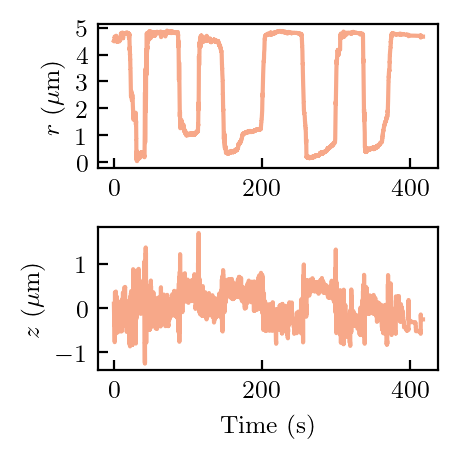

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(6/2.54, 6/2.54))

axes[0].plot(t-t[0], r * 1e6, c=palette[4])
axes[1].plot(t - t[0], z * 1e6 - np.nanmean(z) * 1e6, c=palette[4])

axes[0].set(ylabel=r'$r$ ($\mu$m)')
axes[1].set(xlabel='Time (s)', ylabel=r'$z$ ($\mu$m)')

axes[0].set_yticks([0, 1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

In [30]:
# fig.savefig('traj_two_state.pdf')

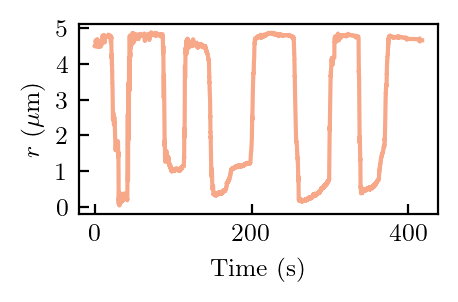

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6/2.54, 4/2.54))

ax.plot(t-t[0], r * 1e6, c=palette[4])

ax.set(xlabel='Time (s)', ylabel=r'$r$ ($\mu$m)')

ax.set_yticks([0, 1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

In [32]:
# fig.savefig('traj_r_two_state.pdf')

## MSDs

In [33]:
fps = 50

kT = 4e-21

In [34]:
N_trajs = np.zeros(Ntot)
for i in range(Ntot):
    x = pos[:,0,i]
    x = x[~np.isnan(x)]
    N_trajs[i] = len(x)

time_trajs = N_trajs / fps

f_glidings = N_glidings / time_trajs

In [35]:
dframes = np.concatenate((np.arange(1,10,1), np.arange(10, 100, 10), np.arange(100, 1000, 100), np.arange(1000, 11000, 1000)))
dtime = dframes / fps

m2rs = np.empty((len(dframes), Ntot))
m2zs = np.empty((len(dframes), Ntot))
m4rs = np.empty((len(dframes), Ntot))
m4zs = np.empty((len(dframes), Ntot))

for j in range(Ntot):
    x, y, z, r, _ = pos[:,:,j].T
    # m2rs[:,j] = moment(2, r, dframes, retrieve_mean=False)
    m2rs[:,j] = (moment(2, x, dframes, retrieve_mean=False) + moment(2, y, dframes, retrieve_mean=False)) / 2
    m2zs[:,j] = moment(2, z, dframes, retrieve_mean=False)
    m4rs[:,j] = (moment(4, x, dframes, retrieve_mean=False) + moment(4, y, dframes, retrieve_mean=False)) / 2
    m4zs[:,j] = moment(4, z, dframes, retrieve_mean=False)

/tmp/ipykernel_88751/3026472617.py:22: RuntimeWarning: Mean of empty slice
  res[i] = np.nanmean(distribution)
/home/n.fares/anaconda3/envs/chlamys/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [36]:
k4rs = m4rs / m2rs ** 2 - 3
k4zs = m4zs / m2zs ** 2 - 3

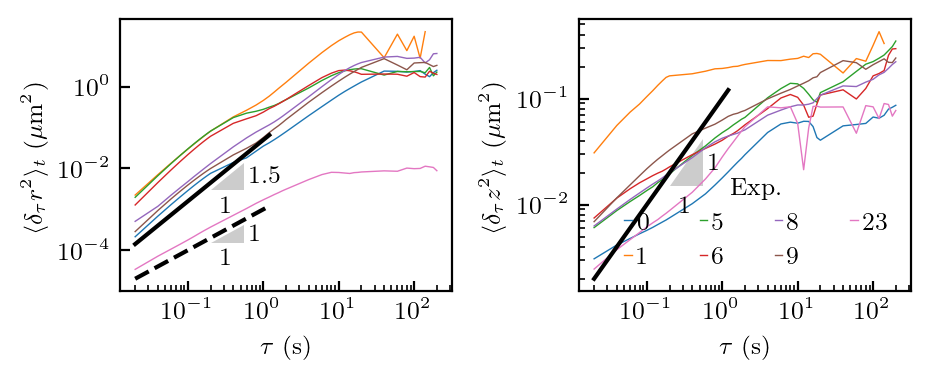

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12/2.54, 5/2.54))

# exps = range(0,Ntot,2)
# exps = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 16, 19, 20, 23]
# exps = [0, 1, 5, 6, 7, 8, 9, 19, 20, 23]
# exps = [0, 5, 6, 19, 23]
# exps = [0, 9, 5, 6, 8, 23]

exps = [0, 1, 5, 6, 8, 9, 23]

for j in exps:
    axes[0].plot(dtime, m2rs[:,j] * 1e12, ls='-', linewidth=0.5, label=str(N_glidings[j]))
    axes[1].plot(dtime, m2zs[:,j] * 1e12, ls='-', linewidth=0.5, label=str(j)) #int(np.nanmean(pos[:,2,j]*1e6))))

axes[0].plot(dtime[:15], 5e-2 * dtime[:15]**1.5, ls='-', c='k')
axes[0].plot(dtime[:15], 1e-3 * dtime[:15], ls='--', c='k')
axes[1].plot(dtime[:15], 1e-1 * dtime[:15], ls='-', c='k')

# D0 = kT / (6 * np.pi * 0.001 * radii[exps[-1]][0])
# axes[0].plot(dtime[:15], 2 * D0 * dtime[:15] * 1e12, ls='-.', c='k')

# axes[0].legend(title=r'\# events', frameon=False,handletextpad=0.2, handlelength=0.3, ncol=Ntot//5)
# axes[1].legend(title=r'$\langle z \rangle_t$ ($\mathrm{\mu m}$)', frameon=False,handletextpad=0.2, handlelength=0.3, ncol=Ntot//5)
axes[1].legend(title=r'Exp.', frameon=False,handletextpad=0.2, handlelength=0.3, ncol=Ntot//5)

axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')
axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau z ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')

annotation.slope_marker((0.2, 3e-3), (1.5, 1), invert=False, ax=axes[0])
annotation.slope_marker((0.2, 1.5e-4), (1, 1), invert=False, ax=axes[0])
annotation.slope_marker((0.2, 1.5e-2), (1, 1), invert=False, ax=axes[1])

plt.tight_layout()
plt.show()

In [38]:
# fig.savefig('MSD_twostate_qualitative_slopes.pdf')

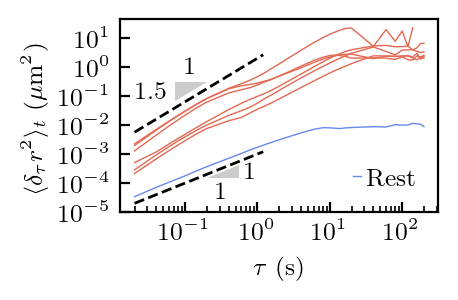

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6/2.54,4/2.54))

for i, j in enumerate(exps):
    if j == 23:
        ax.plot(dtime, m2rs[:,j] * 1e12, ls='-', linewidth=0.5, c=palette[0], label='Rest')
    else:
        ax.plot(dtime, m2rs[:,j] * 1e12, ls='-', linewidth=0.5, c=palette[5])

ax.plot(dtime[:15], 2 * dtime[:15]**1.5, ls='--', c='k', lw=1)
ax.plot(dtime[:15], 1e-3 * dtime[:15], ls='--', c='k', lw=1)

ax.legend(frameon=False,handletextpad=0.2, handlelength=0.3, ncol=Ntot//5)

ax.set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')
ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10])

annotation.slope_marker((0.2, 0.3), (1.5, 1), invert=True, ax=ax)
annotation.slope_marker((0.2, 1.5e-4), (1, 1), invert=False, ax=ax)

plt.tight_layout()
plt.show()

In [40]:
# fig.savefig('MSD_chlamys_twostate.pdf')

In [41]:
for j in exps:
    x, y, z, r, _ = pos[:,:,j].T
    print(len(x[~np.isnan(x)]))

43661
7668
30834
28996
52612
35872
20000


In [42]:
# Spring constants from plateaux 

min_time = 20

plateaux = np.zeros(len(exps)) * np.nan

for i, j in enumerate(exps):
    temp = m2rs[:,j]
    plateaux[i] = np.nanmean(temp[dtime>min_time])

kkk = 2 * 4e-21 / plateaux

print(np.nanmean(kkk[:-1]), np.nanstd(kkk[:-1]))

print(kkk[-1])

2.5547085339253095e-09 1.2032073145757845e-09
8.074159037540773e-07


In [43]:
# Save 
tosave['dtime'] = np.copy(dtime)
tosave['m2rs'] = np.copy(m2rs)
tosave['m2zs'] = np.copy(m2zs)
tosave['m4rs'] = np.copy(m4rs)
tosave['m4zs'] = np.copy(m4zs)
tosave['exps_msd_2state'] = np.copy(exps)

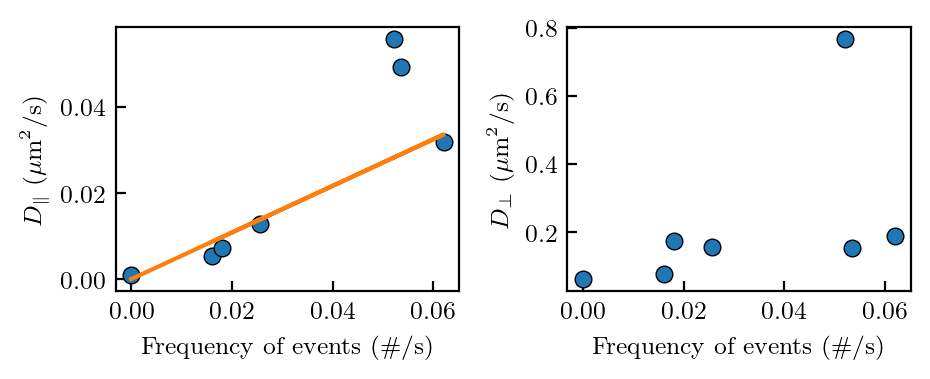

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12/2.54, 5/2.54))

axes[0].plot(f_glidings[exps], m2rs[0,exps]/2/dtime[0]*1e12, ls='', marker='o')
axes[1].plot(f_glidings[exps], m2zs[0,exps]/2/dtime[0]*1e12, ls='', marker='o')

axes[0].plot(f_glidings[exps], 2e-6 ** 2 / np.exp(2) * f_glidings[exps] * 1e12, ls='-')

axes[0].set(xlabel=r'Frequency of events (\#/s)', ylabel=r'$D_\parallel$ ($\mathrm{\mu m ^2 / s}$)')
axes[1].set(xlabel=r'Frequency of events (\#/s)', ylabel=r'$D_\perp$ ($\mathrm{\mu m ^2 / s}$)')

# for i in range(2):
    # axes[i].set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, ])

plt.tight_layout()
plt.show()

In [45]:
exps

[0, 1, 5, 6, 8, 9, 23]

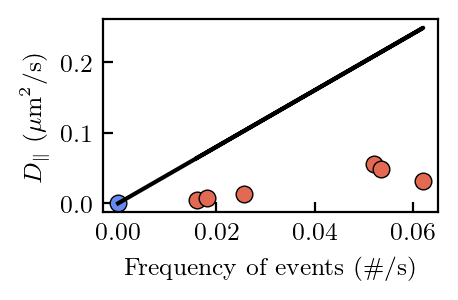

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6/2.54, 4/2.54))

ax.plot(f_glidings[exps][:-1], m2rs[0,exps][:-1]/2/dtime[0]*1e12, ls='', marker='o', c=palette[5])
ax.plot(f_glidings[exps][-1], m2rs[0,exps][-1]/2/dtime[0]*1e12, ls='', marker='o', c=palette[0])

ax.plot(f_glidings[exps], 2e-6 ** 2 * f_glidings[exps] * 1e12, ls='-', c='k')

ax.set(xlabel=r'Frequency of events (\#/s)', ylabel=r'$D_\parallel$ ($\mathrm{\mu m ^2 / s}$)')

# for i in range(2):
    # axes[i].set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, ])

plt.tight_layout()
plt.show()

In [47]:
# fig.savefig('chlamys_twostate_D_para_frequency.pdf')

In [48]:
# fig, axes = plt.subplots(1, 2, figsize=(12/2.54, 5/2.54))

# stop = 10

# for j in exps:
#     axes[0].plot(dtime[:stop], k4rs[:stop,j], ls='-', linewidth=0.5, label=str(N_glidings[j]))
#     axes[1].plot(dtime[:stop], k4zs[:stop,j], ls='-', linewidth=0.5, label=str(j)) #int(np.nanmean(pos[:,2,j]*1e6))))

# axes[1].legend(title=r'Exp.', frameon=False,handletextpad=0.2, handlelength=0.3, ncol=Ntot//5)

# axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'', xscale='log', yscale='log')
# axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'', xscale='log', yscale='log')


# plt.tight_layout()
# plt.show()

In [49]:
# fig, axes = plt.subplots(1, 2, figsize=(12/2.54, 5/2.54))

# axes[0].plot(f_glidings[exps], k4rs[0,exps], ls='', marker='o')
# axes[1].plot(f_glidings[exps], k4zs[0,exps], ls='', marker='o')

# axes[0].set(xlabel=r'Frequency of events (\#/s)', ylabel=r'')
# axes[1].set(xlabel=r'Frequency of events (\#/s)', ylabel=r'')

# plt.tight_layout()
# plt.show()

## Probability of positions

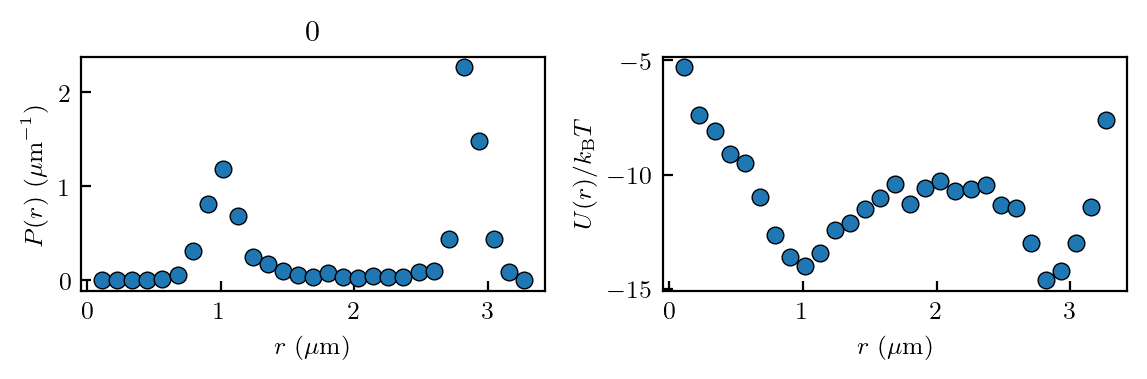

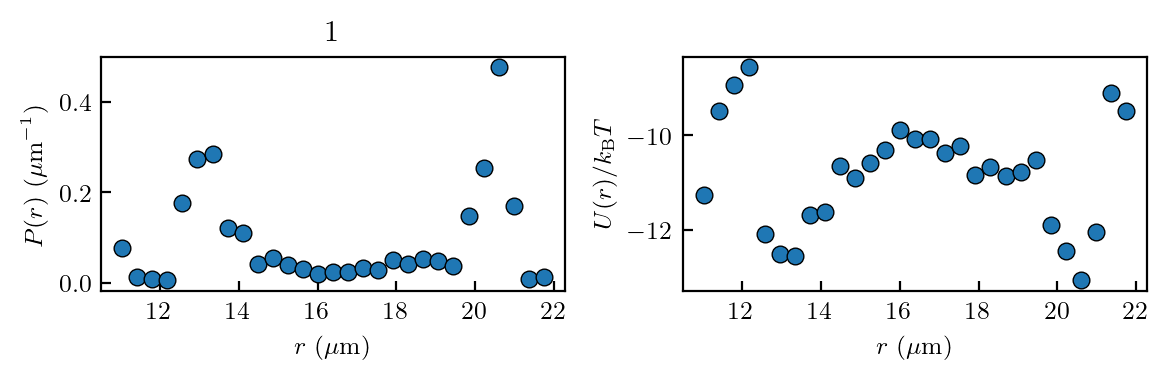

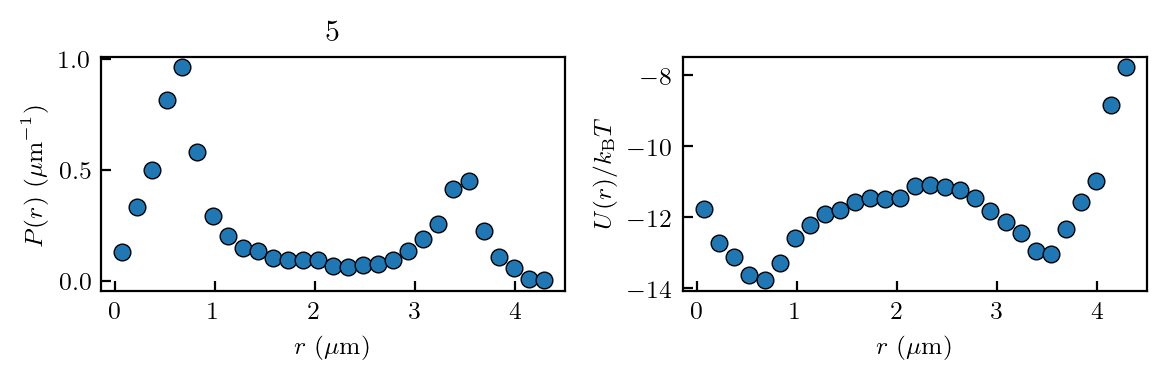

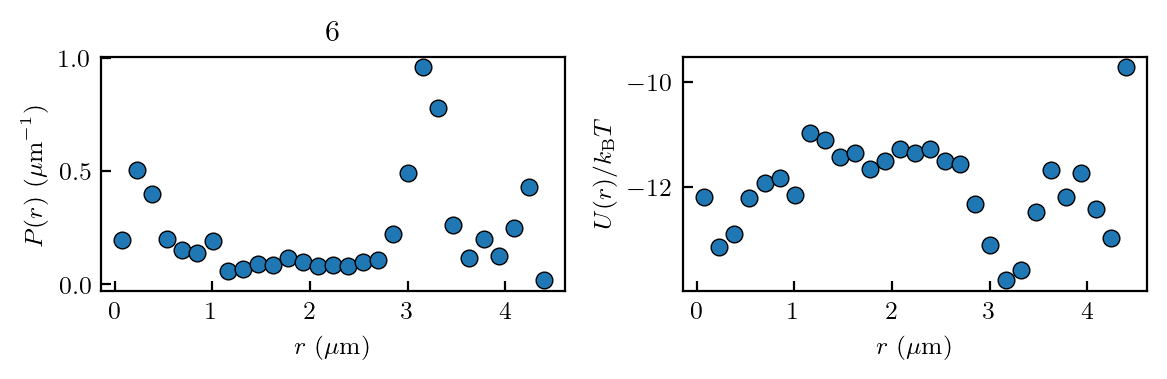

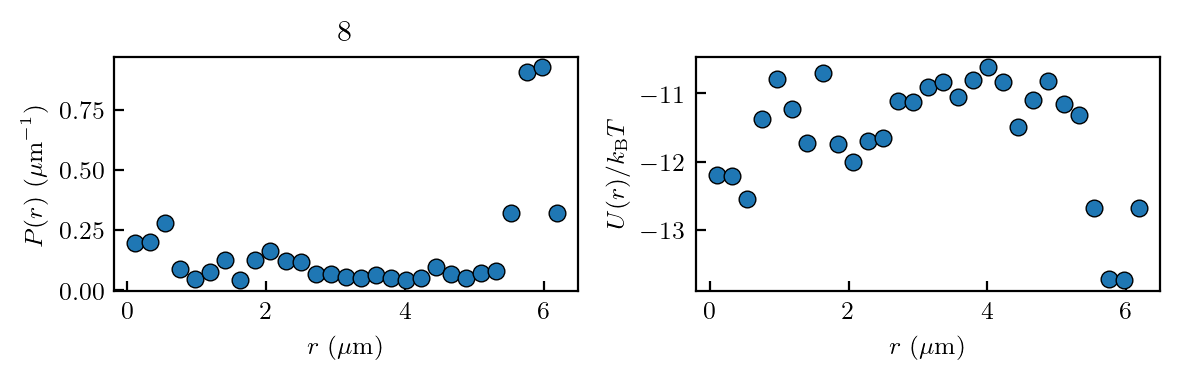

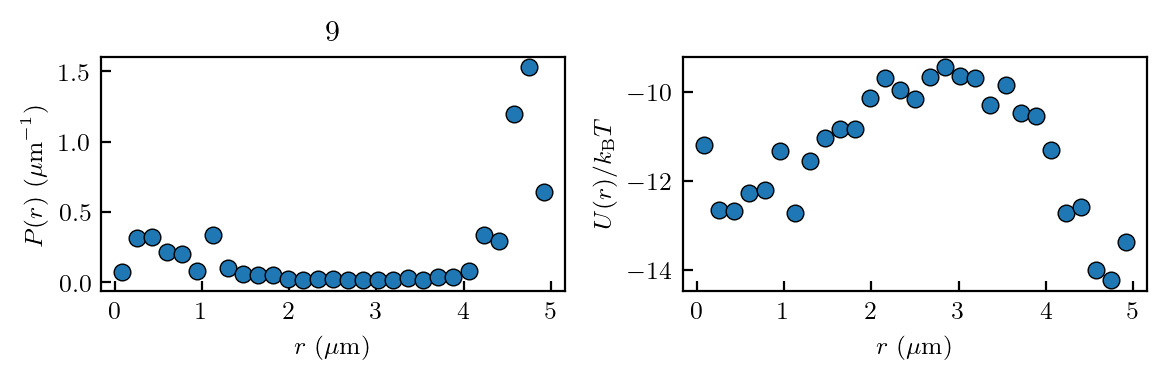

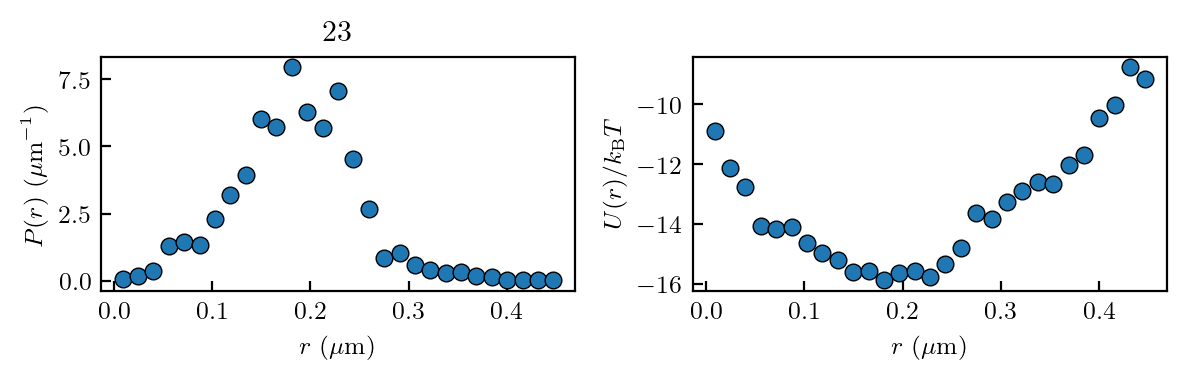

In [50]:
peaks_r = np.empty((Ntot,2))
states_r = np.empty((Ntot,3)) # peak 1, peak 2, in between

for j in exps:
    try:
        r = pos[:,3,j]
        r = r[~np.isnan(r)]
        bins = np.linspace(min(r), max(r), 30)
        pr, bins_pr = pdf(r, bins=bins, density=True)
        pr = pr / np.trapezoid(pr, bins_pr)
        Ur = - kT * np.log(pr)
        # pr_peaks_i = signal.find_peaks(pr, distance=12)[0]
        # Ur_ET = np.nanmean(pr[(bins_pr > bins_pr[pr_peaks_i][0] + 0.5e-6) & (bins_pr < bins_pr[pr_peaks_i][1] - 0.5e-6)])
        fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 5/2.54))
        axes[0].plot(bins_pr * 1e6, pr * 1e-6, 'o')
        # axes[0].plot(bins_pr[pr_peaks_i] * 1e6, pr[pr_peaks_i] * 1e-6, 'x', mec='tab:red')
        # axes[0].plot(bins_pr * 1e6, np.ones(len(bins_pr)) * Ur_ET * 1e-6, '--', c='tab:red')
        axes[0].set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$P(r)$ ($\mathrm{\mu m^{-1}}$)', title=str(j))
        axes[1].plot(bins_pr * 1e6, Ur / kT, 'o')
        axes[1].set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$U(r) / k_\mathrm{B}T$')
        plt.tight_layout()
        plt.show()

        peaks_r[j,0], peaks_r[j,1] = bins_pr[pr_peaks_i]
        states_r[j,0], states_r[j,1] = Ur[pr_peaks_i]
        states_r[j,2] = Ur_ET
        
    except:
        pass

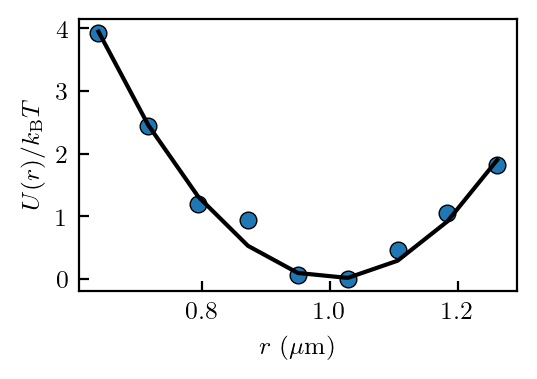

[2.33958545e-07 1.00631026e-06]


In [51]:
# One well 

r = pos[:,3,0]

r = r[~np.isnan(r)]

bins = np.linspace(0.6e-6, 1.3e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
# pr_peaks_i = signal.find_peaks(pr, distance=12)[0]
# Ur_ET = np.nanmean(pr[(bins_pr > bins_pr[pr_peaks_i][0] + 0.5e-6) & (bins_pr < bins_pr[pr_peaks_i][1] - 0.5e-6)])
Ur = Ur
Ur = Ur - np.min(Ur)

g = lambda x, k, x0: 1/2 * k * (x - x0) ** 2

popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])

fig, ax = plt.subplots(1, 1, figsize=(7/2.54, 5/2.54))

ax.plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
ax.plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')

ax.set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$U(r)/k_\mathrm{B}T$')

plt.tight_layout()
plt.show()

print(popt)

In [52]:
# Save 
tosave['kT'] = kT
tosave['Ur_one_peak'] = [bins_pr, Ur]
# tosave['Ur_one_peak_fit'] = 

/tmp/ipykernel_88751/2097642573.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


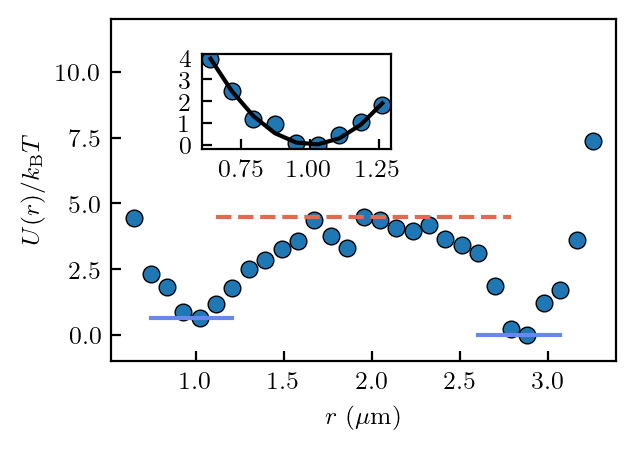

In [65]:
# =========================================
# === Figure for pres 
# =========================================

i = 0
j = exps[i]

# Get traj
r = pos[:,3,j]
r = r[~np.isnan(r)]
# Computation full potential 
bins = np.linspace(0.6e-6, 3.3e-6, 30)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
# Fits
peaks = signal.find_peaks(-Ur, distance=int(0.058 ** -1))[0]
et = np.max(Ur[len(Ur)//2-5:len(Ur)//2+5])
# delta_U[i] = abs(et - np.nanmean(Ur[peaks]))
# Figure 
fig = plt.figure(figsize=(8/2.54, 6/2.54))

ax1 = fig.add_subplot(111)

ax1.plot(bins_pr*1e6, (Ur-np.min(Ur))/kT, ls='', marker='o', mfc='tab:blue')

# ax1.plot(bins_pr[peaks]*1e6, (Ur[peaks]-np.min(Ur))/kT, ls='', marker='x', mec=palette[0])
for i in range(2):
    ax1.plot(bins_pr[peaks[i]-3:peaks[i]+3]*1e6, np.ones(6) * (Ur[peaks[i]]-np.min(Ur))/kT, ls='-', marker='', c=palette[0])

ax1.plot(bins_pr[5:-5]*1e6, np.ones(len(Ur)-10) * (et-np.min(Ur))/kT, ls='--', c=palette[5])

ax1.set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$U(r)/k_\mathrm{B}T$')

# Save
tosave['bins_pr'] = np.copy(bins_pr)
tosave['Ur'] = np.copy(Ur)
tosave['peaks'] = np.copy(peaks)

# Computation peak 1
bins = np.linspace(0.6e-6, 1.3e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
minUr = np.min(Ur)
Ur = Ur - minUr
# Fit
popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])
# spring_r[0,i] = popt[0]

# Update figure
# ax2 = fig.add_subplot(6,6,(2,15))
ax2 = fig.add_axes([0.3, 0.65, 0.3, 0.2])

ax2.plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
ax2.plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')

ax1.set_ylim([-1, 12])
ax2.set_yticks([0, 1, 2, 3, 4])

# Save
tosave['bins_pr_inset'] = np.copy(bins_pr)
tosave['Ur_inset'] = np.copy(Ur)
tosave['Ur_inset_theory'] = g(bins_pr, *popt)

plt.tight_layout()
plt.show()

In [66]:
# fig.savefig('U_r_twostate_exp_0.pdf')

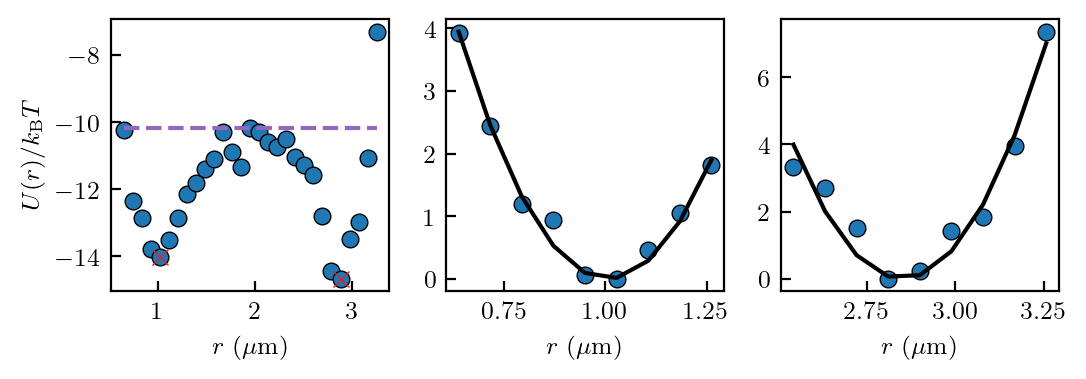

/tmp/ipykernel_88751/712940390.py:75: RuntimeWarning: divide by zero encountered in log
  Ur = - kT * np.log(pr)


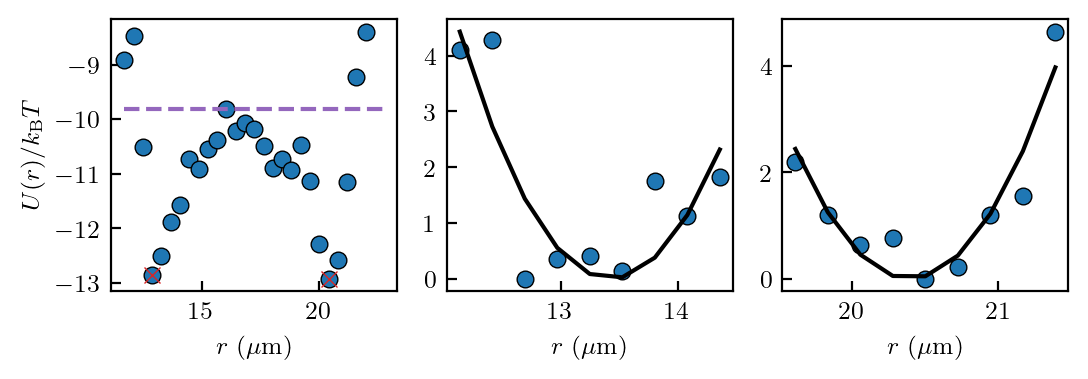

/tmp/ipykernel_88751/712940390.py:127: RuntimeWarning: divide by zero encountered in log
  Ur = - kT * np.log(pr)


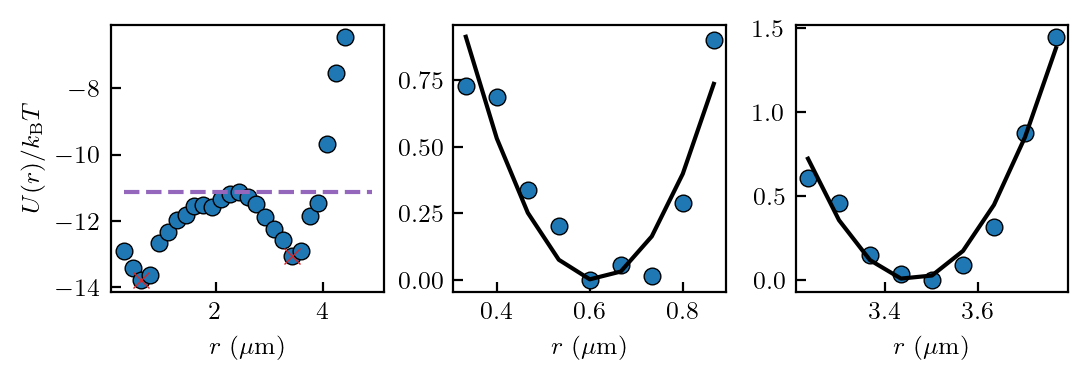

In [67]:
# Repeat over peaks

spring_r = np.zeros((2,len(exps)))
delta_U = np.zeros(len(exps))

# Update the last experiment (no gliding)
spring_r[:,-1] = np.array([np.inf, np.inf])
delta_U[-1] = np.inf

# =========================================
# === 
# =========================================
i = 0
j = exps[i]
# Get traj
r = pos[:,3,j]
r = r[~np.isnan(r)]
# Computation full potential 
bins = np.linspace(0.6e-6, 3.3e-6, 30)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
# Fits
peaks = signal.find_peaks(-Ur, distance=int(0.058 ** -1))[0]
et = np.max(Ur[len(Ur)//2-5:len(Ur)//2+5])
delta_U[i] = abs(et - np.nanmean(Ur[peaks]))
# Figure 
fig, axes = plt.subplots(1, 3, figsize=(14/2.54, 5/2.54))
axes[0].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[0].plot(bins_pr[peaks]*1e6, Ur[peaks]/kT, ls='', marker='x', mec='tab:red')
axes[0].plot(bins_pr*1e6, np.ones(len(Ur)) * et/kT, ls='--', c='tab:purple')
axes[0].set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$U(r)/k_\mathrm{B}T$')
# Computation peak 1
bins = np.linspace(0.6e-6, 1.3e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
Ur = Ur - np.min(Ur)
# Fit
popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])
spring_r[0,i] = popt[0]
# Update figure
axes[1].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[1].plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')
axes[1].set(xlabel=r'$r$ ($\mathrm{\mu m}$)') #, ylabel=r'$U(r)/k_\mathrm{B}T$')
# Computation peak 2
bins = np.linspace(2.5e-6, 3.3e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
Ur = Ur - np.min(Ur)
# Fit
popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])
spring_r[1,i] = popt[0]
# Update figure
axes[2].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[2].plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')
axes[2].set(xlabel=r'$r$ ($\mathrm{\mu m}$)') #, ylabel=r'$U(r)/k_\mathrm{B}T$')
plt.tight_layout()
plt.show()


# =========================================
# === 
# =========================================
i = 1
j = exps[i]
# Get traj
r = pos[:,3,j]
r = r[~np.isnan(r)]
# Computation full potential 
bins = np.linspace(11.5e-6, 23e-6, 30)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
# Fits
peaks = signal.find_peaks(-Ur, distance=int(0.058 ** -1))[0]
et = np.max(Ur[len(Ur)//2-5:len(Ur)//2+5])
delta_U[i] = abs(et - np.nanmean(Ur[peaks]))
# Figure 
fig, axes = plt.subplots(1, 3, figsize=(14/2.54, 5/2.54))
axes[0].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[0].plot(bins_pr[peaks]*1e6, Ur[peaks]/kT, ls='', marker='x', mec='tab:red')
axes[0].plot(bins_pr*1e6, np.ones(len(Ur)) * et/kT, ls='--', c='tab:purple')
axes[0].set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$U(r)/k_\mathrm{B}T$')
# Computation peak 1
bins = np.linspace(12e-6, 14.5e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
Ur = Ur - np.min(Ur)
# Fit
popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])
spring_r[0,i] = popt[0]
# Update figure
axes[1].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[1].plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')
axes[1].set(xlabel=r'$r$ ($\mathrm{\mu m}$)') #, ylabel=r'$U(r)/k_\mathrm{B}T$')
# Computation peak 2
bins = np.linspace(19.5e-6, 21.5e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
Ur = Ur - np.min(Ur)
# Fit
popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])
spring_r[1,i] = popt[0]
# Update figure
axes[2].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[2].plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')
axes[2].set(xlabel=r'$r$ ($\mathrm{\mu m}$)') #, ylabel=r'$U(r)/k_\mathrm{B}T$')
plt.tight_layout()
plt.show()

# =========================================
# === 
# =========================================
i = 2
j = exps[i]
# Get traj
r = pos[:,3,j]
r = r[~np.isnan(r)]
# Computation full potential 
bins = np.linspace(0.2e-6, 5e-6, 30)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
# Fits
peaks = signal.find_peaks(-Ur, distance=int(0.058 ** -1))[0]
et = np.max(Ur[len(Ur)//2-5:len(Ur)//2+5])
delta_U[i] = abs(et - np.nanmean(Ur[peaks]))
# Figure 
fig, axes = plt.subplots(1, 3, figsize=(14/2.54, 5/2.54))
axes[0].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[0].plot(bins_pr[peaks]*1e6, Ur[peaks]/kT, ls='', marker='x', mec='tab:red')
axes[0].plot(bins_pr*1e6, np.ones(len(Ur)) * et/kT, ls='--', c='tab:purple')
axes[0].set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$U(r)/k_\mathrm{B}T$')
# Computation peak 1
bins = np.linspace(0.3e-6, 0.9e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
Ur = Ur - np.min(Ur)
# Fit
popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])
spring_r[0,i] = popt[0]
# Update figure
axes[1].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[1].plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')
axes[1].set(xlabel=r'$r$ ($\mathrm{\mu m}$)') #, ylabel=r'$U(r)/k_\mathrm{B}T$')
# Computation peak 2
bins = np.linspace(3.2e-6, 3.8e-6, 10)
pr, bins_pr = pdf(r, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
Ur = Ur - np.min(Ur)
# Fit
popt, _ = curve_fit(g, bins_pr, Ur, p0=[0.1e-6, 0.])
spring_r[1,i] = popt[0]
# Update figure
axes[2].plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
axes[2].plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')
axes[2].set(xlabel=r'$r$ ($\mathrm{\mu m}$)') #, ylabel=r'$U(r)/k_\mathrm{B}T$')
plt.tight_layout()
plt.show()



In [68]:
spring_r * 1e9

array([[233.958545  ,  21.30812004,  92.52396625,   0.        ,
          0.        ,   0.        ,          inf],
       [341.37496297,  31.97450391, 115.47398178,   0.        ,
          0.        ,   0.        ,          inf]])

In [69]:
delta_U

array([1.66189871e-20, 1.22888216e-20, 9.14803454e-21, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00,            inf])

In [70]:
# Save 
tosave['spring_r'] = np.copy(spring_r)
tosave['delta_U'] = np.copy(delta_U)

## Probability of displacements: One Experiment

In [71]:
# Auxiliary Functions

# Compute proba of displacements 
def _compute_proba_dx(x, di, bins=30, use_cutoff=3, min_dx=None):
    dx = x[di:] - x[:-di]
    if use_cutoff != None:
        cutoff = use_cutoff * np.std(dx)
        index = np.abs(dx) < cutoff
        dx = dx[index]
    if min_dx != None:
        index = np.abs(dx) >= min_dx
        dx = dx[index]
    hist, bins_center = pdf(dx[~np.isnan(dx)], bins=bins)
    hist = hist / np.trapezoid(hist, bins_center)
    bins_center_norm = bins_center / np.std(dx)
    hist_norm = hist / np.trapezoid(hist, bins_center / np.std(dx))
    return hist, bins_center, hist_norm, bins_center_norm

def compute_proba_dx(str_x, bins, use_cutoff=3, min_dx=None):
    res = {}
    x = str2var(str_x)
    timesteps = str2var('timesteps_d' + str_x)
    for n, di in enumerate(timesteps):
        hist, bins_center, hist_norm, bins_center_norm = _compute_proba_dx(x, di, bins=bins, use_cutoff=use_cutoff, min_dx=min_dx)
        res["proba_d{0}_short_t_{1}".format(str_x, di)] = [np.copy(bins_center), np.copy(hist)]
        res["normalized_proba_d{0}_short_t_{1}".format(str_x, di)] = [np.copy(bins_center_norm), np.copy(hist_norm)]
    return res

# Get back computed proba of displacements
def get_back_proba(str_x, n=0):
    probas = str2var('probas_d' + str_x)
    timesteps = str2var('timesteps_d' + str_x)
    di = timesteps[n]
    which = "proba_d{0}_short_t_{1}".format(str_x, di)
    prob = probas[which]
    return prob

In [72]:
# Moving chlamys

# Timesteps to compute displacements
timesteps_dr = [10]
timesteps_dz = [10]

# Trajectory
index_moving = 9
x, y, z, r, _ = pos[:,:,index_moving].T
r, z = r[~np.isnan(r)], z[~np.isnan(z)] # Be carful with this kind of line

# Compute probas
probas_dr = compute_proba_dx('r', bins=30, use_cutoff=5, min_dx=1e-9)
probas_dz = compute_proba_dx('z', bins=30, use_cutoff=3, min_dx=1e-9)

In [73]:
# Resting chlamys

# Timesteps to compute displacements
timesteps_dr_rest = timesteps_dr
timesteps_dz_rest = timesteps_dz

# Trajectory
index_resting = 23
x_rest, y_rest, z_rest, r_rest, _ = pos[:,:,index_resting].T
r_rest, z_rest = r_rest[~np.isnan(r_rest)], z_rest[~np.isnan(z_rest)]

# Compute probas
probas_dr_rest = compute_proba_dx('r_rest', bins=30, use_cutoff=5, min_dx=1e-9)
probas_dz_rest = compute_proba_dx('z_rest', bins=30, use_cutoff=3, min_dx=1e-9)

In [74]:
# Auxiliary functions: fitting PDF

def gaussian(x, D, dt):
    res = np.exp(- x ** 2 / (4 * D * dt)) / np.sqrt(4*np.pi*D*dt) 
    return res
    
def compute_gaussian_theory(str_x, n=0, nbins=30):
    timesteps = str2var('timesteps_d' + str_x)
    di = timesteps[n]
    dt = di / fps
    if str_x == 'z':
        D = D0 * mean_D_perp_from_MSD
    else:
        D = D0 * mean_D_para_from_MSD
    bc_dx_theory = define_bins_centers_theory(str_x, n=n, nbins=nbins)
    hist_dx_theory = gaussian(bc_dx_theory, D, dt)
    return bc_dx_theory, hist_dx_theory

def fit_to_gaussian(str_x, n=0, nbins=30, p0=[0.5, 1]):
    prob = get_back_proba(str_x, n=n)
    timesteps = str2var('timesteps_d' + str_x)
    di = timesteps[n]
    dt = di / fps
    f = lambda x, gg, A: A * np.exp(-x**2 / gg)
    dx = prob[0]
    pdx = prob[1]
    # dx = dx[pdx != -np.inf]
    # pdx = pdx[pdx != -np.inf]
    cond = np.abs(dx) >= 0.
    popt, _ = curve_fit(lambda x, gg, A: np.log(f(x, gg, A)), dx[cond], np.log(pdx[cond]), p0=p0)
    gg, A = popt[0], popt[1]
    bc_dx_theory = define_bins_centers_theory(str_x, n=n, nbins=nbins)
    hist_dx_theory = f(bc_dx_theory, gg, A)
    return bc_dx_theory, hist_dx_theory, gg, A

def lorentzian(x, gg):
    res = 2/(np.pi*gg) / (1 + (2*x/gg) ** 2)
    return res

def _define_bins_centers_theory(bins_centers_exp, nbins=30):
    m = np.max(bins_centers_exp)
    return np.linspace(-m, m, nbins)

def define_bins_centers_theory(str_x, n=0, nbins=30):
    probas = str2var('probas_d' + str_x)
    timesteps = str2var('timesteps_d' + str_x)
    di = timesteps[n]
    which = "proba_d{0}_short_t_{1}".format(str_x, di)
    bins_centers_exp = probas[which][0]
    return _define_bins_centers_theory(bins_centers_exp, nbins=nbins)
    
def fit_to_lorentzian(str_x, n=0, nbins=30, p0=[1]):
    prob = get_back_proba(str_x, n=n)
    popt, _ = curve_fit(lorentzian, prob[0], prob[1], p0=p0)
    gg = popt[0]
    bc_dx_theory = define_bins_centers_theory(str_x, n=n, nbins=nbins)
    hist_dx_theory = lorentzian(bc_dx_theory, gg)
    return bc_dx_theory, hist_dx_theory, gg

In [75]:
index = 0
bc_dr_theory, hist_dr_theory, _ = fit_to_lorentzian('r', n=index, nbins=50, p0=[1e-7])
bc_dr_rest_theory, hist_dr_rest_theory, _ = fit_to_lorentzian('r_rest', n=index, nbins=50, p0=[1e-7])
bc_dr_rest_theory_bis, hist_dr_rest_theory_bis, _, _ = fit_to_gaussian('r_rest', n=0, nbins=20, p0=[1e-16, 1e8])

/tmp/ipykernel_88751/3926194432.py:30: RuntimeWarning: invalid value encountered in log
  popt, _ = curve_fit(lambda x, gg, A: np.log(f(x, gg, A)), dx[cond], np.log(pdx[cond]), p0=p0)


In [76]:
colors = ['tab:blue', 'tab:red', 'tab:purple', 'tab:green', 'tab:orange']

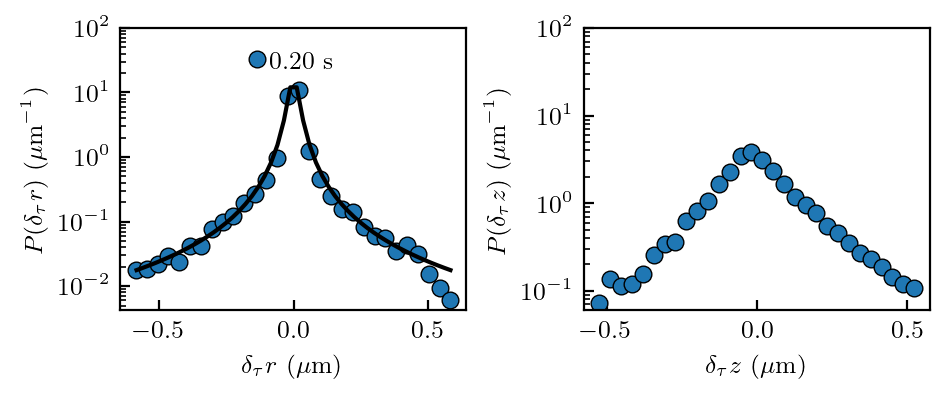

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12/2.54,5/2.54))

for n, di in enumerate(timesteps_dr):
    bins_center, hist = probas_dr["proba_dr_short_t_{}".format(di)]
    axes[0].plot(bins_center * 1e6, hist * 1e-6, 'o', mfc=colors[n], label="{:.2f} s".format(di/fps))
for n, di in enumerate(timesteps_dz):
    bins_center, hist = probas_dz["proba_dz_short_t_{}".format(di)]
    axes[1].plot(bins_center * 1e6, hist * 1e-6, 'o', mfc=colors[n], label="{:.2f} s".format(di/fps))

axes[0].plot(bc_dr_theory * 1e6, hist_dr_theory * 1e-6, ls='-', c='k') #colors[timesteps_dr[index]-1])
# axes[1].plot(bc_dz_theory * 1e6, hist_dz_theory * 1e-6, ls='-', c='k')

axes[0].set(xlabel=r"$\delta_\tau r$ ($\mathrm{\mu m}$)", ylabel=r"$P(\delta_\tau r)$ ($\mathrm{\mu m ^{-1}}$)")
axes[1].set(xlabel=r"$\delta_\tau z$ ($\mathrm{\mu m}$)", ylabel=r"$P(\delta_\tau z)$ ($\mathrm{\mu m ^{-1}}$)")
for ax in axes:
    locmaj = mpl.ticker.LogLocator(base=10,numticks=10) 
    ax.yaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=6)
    ax.yaxis.set_minor_locator(locmin)
    ax.set(xscale='linear', yscale='log')
    ax.set_ylim([None, 1e2])

axes[0].legend(frameon=False, loc='upper center', handletextpad=0.3, handlelength=0.3, ncol=3, columnspacing=0.5)

plt.tight_layout(pad=0.7)
plt.show()

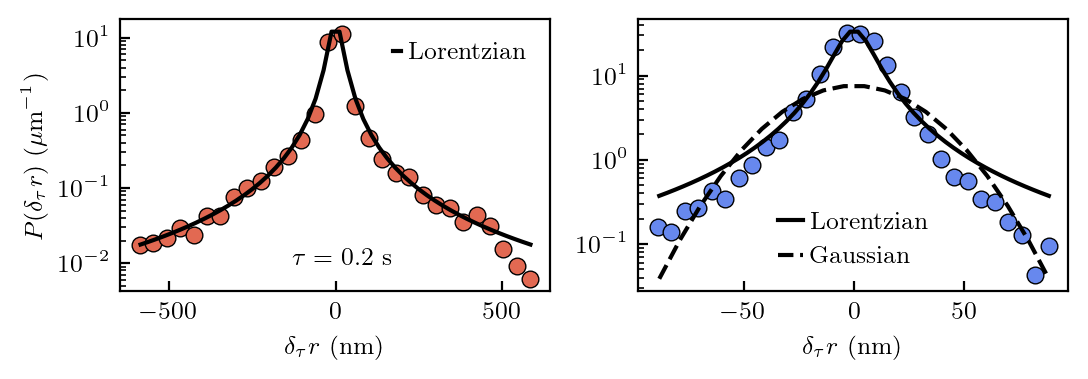

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14/2.54,5/2.54))

n = 0
di = timesteps_dr[n]
bins_center, hist = probas_dr["proba_dr_short_t_{}".format(di)]
axes[0].plot(bins_center * 1e9, hist * 1e-6, 'o', mfc=palette[5]) #, label="{:.2f} s".format(di/fps)) #mfc=colors[di-1]
n = 0
di = timesteps_dr_rest[n]
bins_center, hist = probas_dr_rest["proba_dr_rest_short_t_{}".format(di)]
axes[1].plot(bins_center * 1e9, hist * 1e-6, 'o', mfc=palette[0]) #, label="{:.2f} s".format(di/fps), zorder=-1) #mfc=colors[di-1]
    
axes[0].plot(bc_dr_theory * 1e9, hist_dr_theory * 1e-6, ls='-', c='k', label='Lorentzian')

axes[1].plot(bc_dr_rest_theory * 1e9, hist_dr_rest_theory * 1e-6, ls='-', c='k', label='Lorentzian')
axes[1].plot(bc_dr_rest_theory_bis * 1e9, hist_dr_rest_theory_bis * 1e-6, ls='--', c='k', label='Gaussian')

axes[0].set(xlabel=r"$\delta_\tau r$ ($\mathrm{nm}$)", ylabel=r"$P(\delta_\tau r)$ ($\mathrm{\mu m ^{-1}}$)")

axes[1].set(xlabel=r"$\delta_\tau r$ ($\mathrm{nm}$)", xscale='linear', yscale='log')

locmaj = mpl.ticker.LogLocator(base=10,numticks=10) 
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=6)
axes[0].yaxis.set_minor_locator(locmin)
axes[0].set(xscale='linear', yscale='log')
# ax.set_ylim([None, 5e2])
# axes[0].set_xticks([-60, -30, 0, 30, 60])

axes[0].legend(frameon=False, loc='upper right', handletextpad=0.3, handlelength=0.3, ncol=3, columnspacing=0.5)
axes[1].legend(frameon=False, loc='lower center', handletextpad=0.3, handlelength=1, ncol=1, columnspacing=0.5)

axes[0].annotate(r'$\tau = $ 0.2 s', xy=(0.4,0.1), xycoords='axes fraction')

plt.tight_layout()
plt.show()

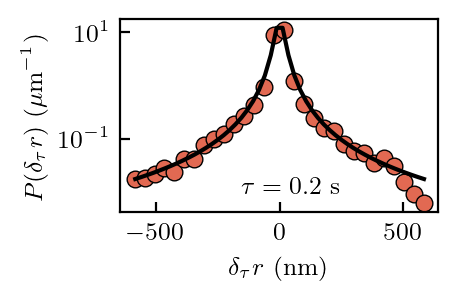

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(6/2.54,4/2.54))

for n, di in enumerate(timesteps_dr):
    bins_center, hist = probas_dr["proba_dr_short_t_{}".format(di)]
    ax.plot(bins_center * 1e9, hist * 1e-6, 'o', mfc=palette[5], label="{:.2f} s".format(di/fps)) #mfc=colors[di-1]
    # bins_center, hist = probas_dr_rest["proba_dr_short_t_{}".format(di)]
    # ax.plot(bins_center[abs(bins_center) < 30e-9] * 1e9, hist[abs(bins_center) < 30e-9] * 1e-6, 'o', mfc=palette[0], label="{:.2f} s".format(di/fps), zorder=-1) #mfc=colors[di-1]
    
ax.plot(bc_dr_theory * 1e9, hist_dr_theory * 1e-6, ls='-', c='k')

ax.set(xlabel=r"$\delta_\tau r$ ($\mathrm{nm}$)", ylabel=r"$P(\delta_\tau r)$ ($\mathrm{\mu m ^{-1}}$)")

locmaj = mpl.ticker.LogLocator(base=10,numticks=10) 
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=6)
ax.yaxis.set_minor_locator(locmin)
ax.set(xscale='linear', yscale='log')
# ax.set_ylim([None, 5e2])
# ax.set_xticks([-60, -30, 0, 30, 60])

# ax.legend(frameon=False, loc='upper center', handletextpad=0.3, handlelength=0.3, ncol=3, columnspacing=0.5)

ax.annotate(r'$\tau = 0.2$ s', xy=(0.38,0.1), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [80]:
# fig.savefig('P_dr_chlamys_twostate.pdf')

# Analysis Gliding Vs. No Gliding: ``One Long Gliding''

In [81]:
exps = [12, 13, 14, 15, 18]

start_g = [6100, 3100, 7000, 6100, None]
stop_g = [10000, 5500, 8000, 8100, None]

start_nog = [5000, 2500, None, 2000, 4000]
stop_nog = [6000, 3000, None, 4000, 8000]

# colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'royalblue']

## Choose Experiment

In [82]:
i = -2

expj = exps[i]

start, stop = start_g[i], stop_g[i]

x, y, z, r, t = pos[start:stop,:,expj].T

start, stop = start_nog[i], stop_nog[i]

xnog, ynog, znog, rnog, tnog = pos[start:stop,:,expj].T

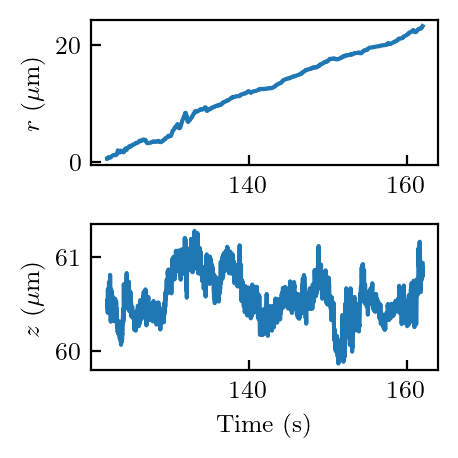

In [83]:
fig, axes = plt.subplots(2, 1, figsize=(6/2.54, 6/2.54))

axes[0].plot(t, r * 1e6, c='tab:blue')
axes[1].plot(t, z * 1e6, c='tab:blue')

axes[0].set(ylabel=r'$r$ ($\mu$m)')
axes[1].set(xlabel='Time (s)', ylabel=r'$z$ ($\mu$m)')

plt.tight_layout()
plt.show()

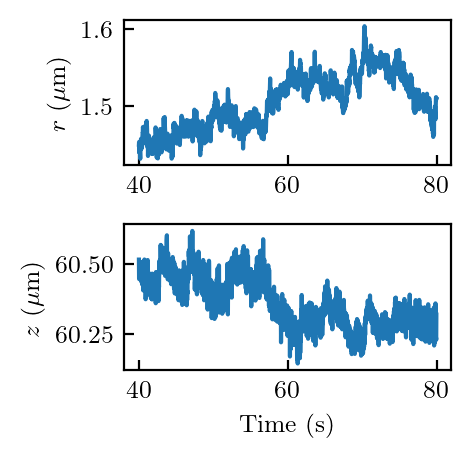

In [84]:
fig, axes = plt.subplots(2, 1, figsize=(6/2.54, 6/2.54))

axes[0].plot(tnog, rnog * 1e6, c='tab:blue')
axes[1].plot(tnog, znog * 1e6, c='tab:blue')

axes[0].set(ylabel=r'$r$ ($\mu$m)')
axes[1].set(xlabel='Time (s)', ylabel=r'$z$ ($\mu$m)')

plt.tight_layout()
plt.show()

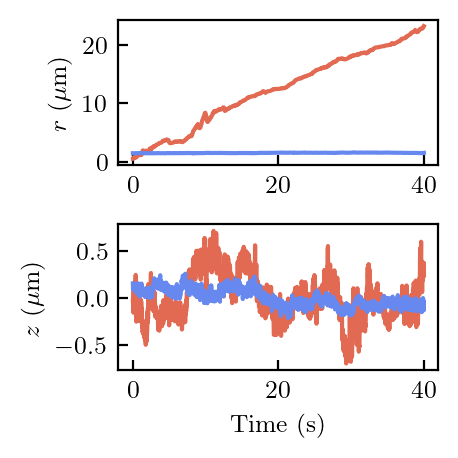

In [85]:
fig, axes = plt.subplots(2, 1, figsize=(6/2.54, 6/2.54))

axes[0].plot(t-t[0], r * 1e6, c=palette[5])
axes[0].plot(tnog[:len(r)] - tnog[0], rnog[:len(r)] * 1e6, c=palette[0])
axes[1].plot(t - t[0], z * 1e6 - np.nanmean(z) * 1e6, c=palette[5])
axes[1].plot(tnog[:len(r)] - tnog[0], znog[:len(r)] * 1e6 - np.nanmean(znog) * 1e6, c=palette[0])

axes[0].set(ylabel=r'$r$ ($\mu$m)')
axes[1].set(xlabel='Time (s)', ylabel=r'$z$ ($\mu$m)')

axes[0].set_yticks([0, 10, 20])

plt.tight_layout()
plt.show()

In [86]:
# fig.savefig('traj_random_walk_state_gliding_vs_no_gliding.pdf')

### Probability of Presence & Potential

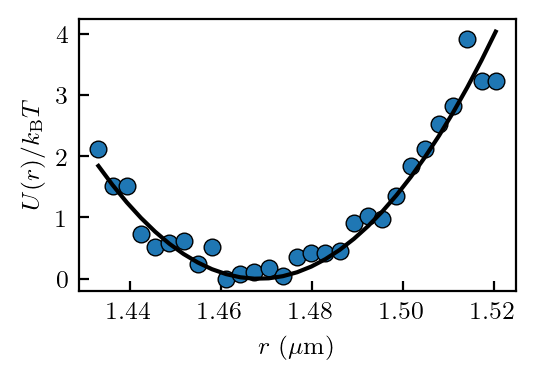

[1.18716827e-05 1.46826329e-06]


In [87]:
# One well 

rtemp = rnog[:]

rtemp = rtemp[:len(rtemp)//3]

bins = np.linspace(min(rtemp), max(rtemp), 30)
pr, bins_pr = pdf(rtemp, bins=bins, density=True)
pr = pr / np.trapezoid(pr, bins_pr)
Ur = - kT * np.log(pr)
Ur = Ur
Ur = Ur - np.min(Ur)

g = lambda x, k, x0: 1/2 * k * (x - x0) ** 2

popt, _ = curve_fit(g, bins_pr, Ur, p0=[1e-6, 0.])

fig, ax = plt.subplots(1, 1, figsize=(7/2.54, 5/2.54))
ax.plot(bins_pr*1e6, Ur/kT, ls='', marker='o')
ax.plot(bins_pr*1e6, g(bins_pr, *popt)/kT, ls='-', c='k')
ax.set(xlabel=r'$r$ ($\mathrm{\mu m}$)', ylabel=r'$U(r)/k_\mathrm{B}T$')
plt.tight_layout()
plt.show()

print(popt)

In [88]:
np.sqrt(4e-21/12e-6)

np.float64(1.8257418583505536e-08)

### Mobility

In [89]:
dframes = np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, 10))) 
dtime = dframes / fps

msdr = moment(2, r, dframes, retrieve_mean=True)
msdrnog = moment(2, rnog, dframes, retrieve_mean=True)

msdz = moment(2, z, dframes, retrieve_mean=True)
msdznog = moment(2, znog, dframes, retrieve_mean=True)

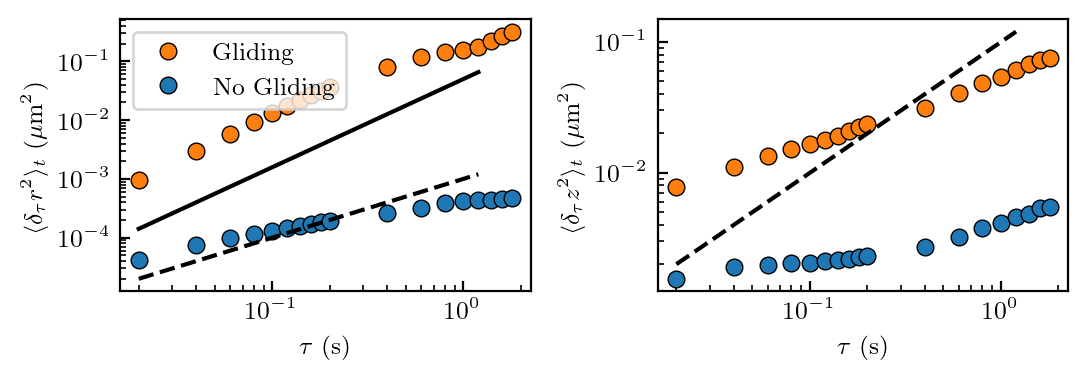

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(14/2.54, 5/2.54))

axes[0].loglog(dtime, msdr * 1e12, 'o', c='tab:orange', label='Gliding')
axes[0].loglog(dtime, msdrnog * 1e12, 'o', c='tab:blue', label='No Gliding')

axes[1].loglog(dtime, msdz * 1e12, 'o', c='tab:orange', label='Gliding')
axes[1].loglog(dtime, msdznog * 1e12, 'o', c='tab:blue', label='No Gliding')

axes[0].plot(dtime[:15], 5e-2 * dtime[:15]**1.5, ls='-', c='k')
axes[0].plot(dtime[:15], 1e-3 * dtime[:15], ls='--', c='k')
axes[1].plot(dtime[:15], 1e-1 * dtime[:15], ls='--', c='k')

axes[0].legend()
# axes[1].legend()

axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)')
axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau z ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)')

plt.tight_layout()
plt.show()

### Gliding Speed

In [91]:
m1r = moment(1, r, dframes, retrieve_mean=False)
m1rnog = moment(1, rnog, dframes, retrieve_mean=False)

m1z = moment(1, z, dframes, retrieve_mean=False)
m1znog = moment(1, znog, dframes, retrieve_mean=False)

In [92]:
f = lambda x, a: a * x

popt, _ = curve_fit(f, dframes[~np.isnan(m1r)][:10]/fps, m1r[~np.isnan(m1r)][:10])
v = popt[0] 
poptnog, _ = curve_fit(f, dframes[~np.isnan(m1rnog)][:10]/fps, m1rnog[~np.isnan(m1rnog)][:10])
vnog = poptnog[0]

poptz, _ = curve_fit(f, dframes[~np.isnan(m1z)][:10]/fps, m1z[~np.isnan(m1z)][:10])
vz = poptz[0] 
poptznog, _ = curve_fit(f, dframes[~np.isnan(m1znog)][:10]/fps, m1znog[~np.isnan(m1znog)][:10])
vznog = poptznog[0]

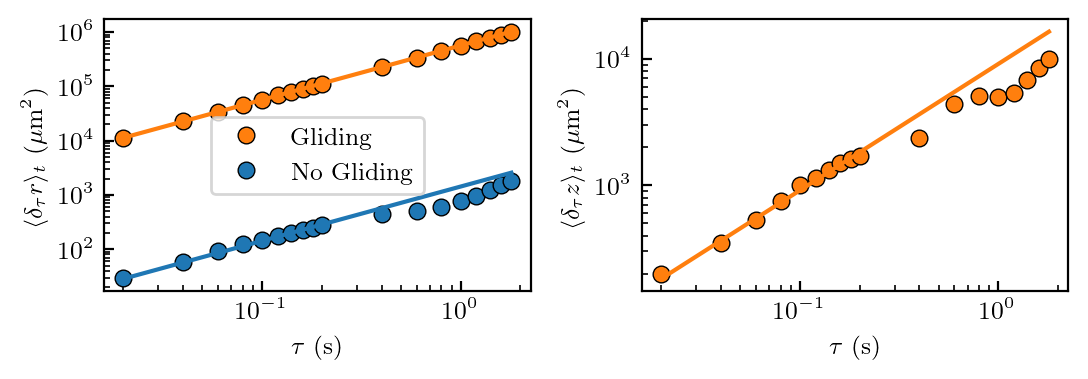

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14/2.54, 5/2.54))

axes[0].loglog(dtime, m1r * 1e12, 'o', c='tab:orange', label='Gliding')
axes[0].loglog(dtime, m1rnog * 1e12, 'o', c='tab:blue', label='No Gliding')
axes[0].plot(dtime, f(dtime, *popt) * 1e12, ls='-', c='tab:orange')
axes[0].plot(dtime, f(dtime, *poptnog) * 1e12, ls='-', c='tab:blue')

axes[1].loglog(dtime, m1z * 1e12, 'o', c='tab:orange', label='Gliding')
axes[1].loglog(dtime, m1znog * 1e12, 'o', c='tab:blue', label='No Gliding')
axes[1].plot(dtime, f(dtime, *poptz) * 1e12, ls='-', c='tab:orange')
axes[1].plot(dtime, f(dtime, *poptznog) * 1e12, ls='-', c='tab:blue')

axes[0].legend()
# axes[1].legend()

axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r \rangle_t$ ($\mathrm{\mu m ^2}$)')
axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau z \rangle_t$ ($\mathrm{\mu m ^2}$)')

plt.tight_layout()
plt.show()

In [94]:
v * 1e6

np.float64(0.5664876176762556)

In [95]:
vnog * 1e6

np.float64(0.0014286908952361877)

In [96]:
vz * 1e6

np.float64(0.009112284108894074)

In [97]:
vznog * 1e6

np.float64(-0.005257416895682889)

### Probability of displacements: No-Gliding Intervals

In [98]:
timesteps_dr = [1]
timesteps_dz = [1]
timesteps_drnog = [1, 2, 10]
timesteps_dznog = [1, 2, 10]

In [99]:
probas_dr = compute_proba_dx('r', bins=30)
probas_dz = compute_proba_dx('z', bins=30)
probas_drnog = compute_proba_dx('rnog', bins=30, use_cutoff=5)
probas_dznog = compute_proba_dx('znog', bins=30)

In [100]:
index = 2
bc_drnog_theory, hist_drnog_theory, gg_rnog, A_nog = fit_to_gaussian('rnog', n=index, nbins=30, p0=[1e-16, 1e9])

/tmp/ipykernel_88751/3926194432.py:30: RuntimeWarning: invalid value encountered in log
  popt, _ = curve_fit(lambda x, gg, A: np.log(f(x, gg, A)), dx[cond], np.log(pdx[cond]), p0=p0)


In [101]:
# colors = ['tab:blue', 'tab:red', 'tab:purple']
# markers = ['o', 'h', 's']

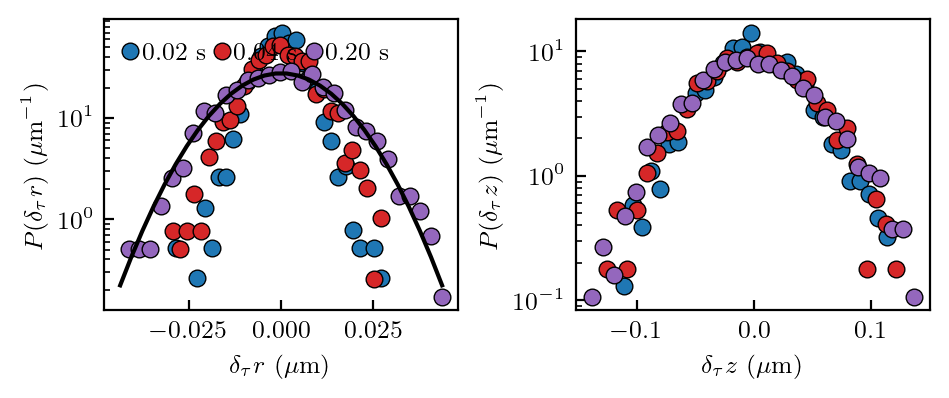

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(12/2.54,5/2.54))

# for n, di in enumerate(timesteps_dr):
#     bins_center, hist = probas_dr["proba_dr_short_t_{}".format(di)]
#     axes[0].plot(bins_center * 1e6, hist * 1e-6, 'o', mfc='tab:orange', label="{:.2f} s".format(di/fps))
for n, di in enumerate(timesteps_drnog):
    bins_center, hist = probas_drnog["proba_drnog_short_t_{}".format(di)]
    axes[0].plot(bins_center * 1e6, hist * 1e-6, 'o', mfc=colors[n], label="{:.2f} s".format(di/fps))
# for n, di in enumerate(timesteps_dz):
#     bins_center, hist = probas_dz["proba_dz_short_t_{}".format(di)]
#     axes[1].plot(bins_center * 1e6, hist * 1e-6, 'o', mfc='tab:orange', label="{:.2f} s".format(di/fps))
for n, di in enumerate(timesteps_dznog):
    bins_center, hist = probas_dznog["proba_dznog_short_t_{}".format(di)]
    axes[1].plot(bins_center * 1e6, hist * 1e-6, 'o', mfc=colors[n], label="{:.2f} s".format(di/fps))

axes[0].plot(bc_drnog_theory * 1e6, hist_drnog_theory * 1e-6, ls='-', c='k')

axes[0].set(xlabel=r"$\delta_\tau r$ ($\mathrm{\mu m}$)", ylabel=r"$P(\delta_\tau r)$ ($\mathrm{\mu m ^{-1}}$)")
axes[1].set(xlabel=r"$\delta_\tau z$ ($\mathrm{\mu m}$)", ylabel=r"$P(\delta_\tau z)$ ($\mathrm{\mu m ^{-1}}$)")
for ax in axes:
    locmaj = mpl.ticker.LogLocator(base=10,numticks=10) 
    ax.yaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10,subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=6)
    ax.yaxis.set_minor_locator(locmin)
    ax.set(xscale='linear', yscale='log')

axes[0].legend(frameon=False, loc='upper left', handletextpad=0.3, handlelength=0.3, ncol=3, columnspacing=0.5)

plt.tight_layout(pad=0.7)
plt.show()

## Several Experiments

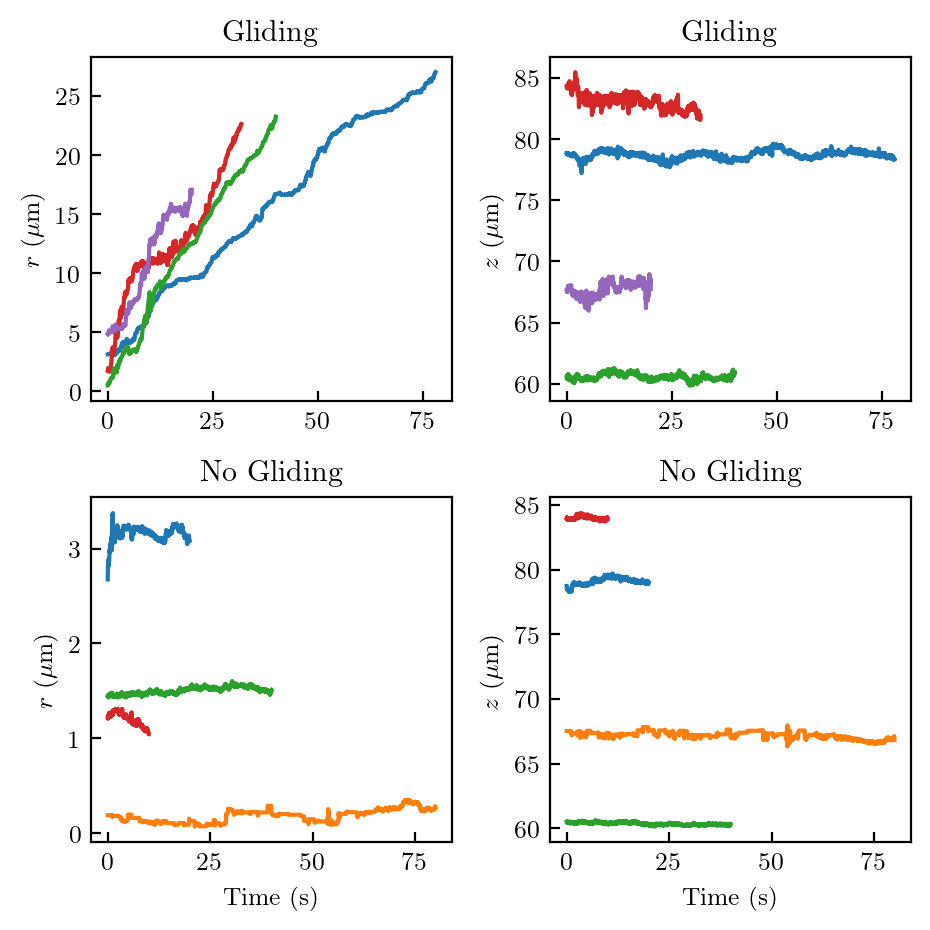

In [103]:
# Plot trajectories 

fig, axes = plt.subplots(2, 2, figsize=(12/2.54, 12/2.54))

for i, j in enumerate(exps):
    _, _, zz, rr, tt = pos[:,:,j].T
    if start_g[i] != None:
        r, z = rr[start_g[i]:stop_g[i]], zz[start_g[i]:stop_g[i]]
        t = tt[start_g[i]:stop_g[i]] - tt[start_g[i]]
        axes[0,0].plot(t, r * 1e6, ls='-', color=colors[i])
        axes[0,1].plot(t, z * 1e6, ls='-', color=colors[i])
    if start_nog[i] != None:
        rnog, znog = rr[start_nog[i]:stop_nog[i]], zz[start_nog[i]:stop_nog[i]]
        tnog = tt[start_nog[i]:stop_nog[i]] - tt[start_nog[i]]
        axes[1,0].plot(tnog, rnog * 1e6, ls='-', color=colors[i])
        axes[1,1].plot(tnog, znog * 1e6, ls='-', color=colors[i])

axes[0,0].set(xlabel=r'', ylabel=r'$r$ ($\mu$m)', title='Gliding')
axes[0,1].set(xlabel=r'', ylabel=r'$z$ ($\mu$m)', title='Gliding')
axes[1,0].set(xlabel=r'Time (s)', ylabel=r'$r$ ($\mu$m)', title='No Gliding')
axes[1,1].set(xlabel=r'Time (s)', ylabel=r'$z$ ($\mu$m)', title='No Gliding')

plt.tight_layout()
plt.show()

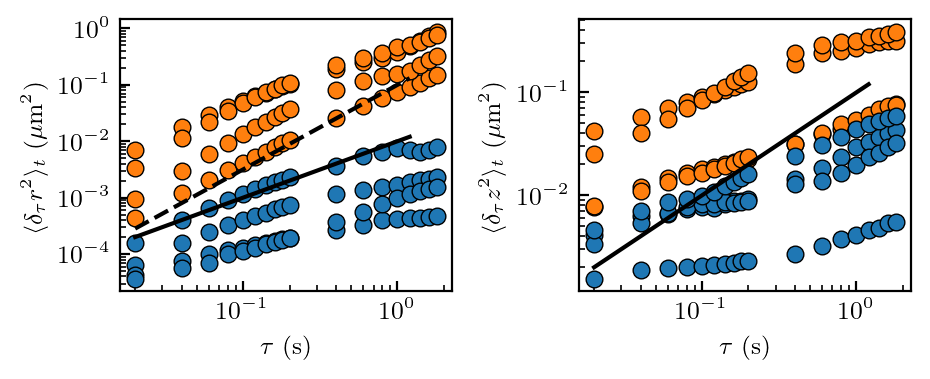

In [104]:
m2rs, m2zs = np.ones((len(dframes), len(exps))) * np.nan, np.ones((len(dframes), len(exps))) * np.nan
m2rs_nog, m2zs_nog = np.ones((len(dframes), len(exps))) * np.nan, np.ones((len(dframes), len(exps))) * np.nan

fig, axes = plt.subplots(1, 2, figsize=(12/2.54, 5/2.54))

for i, j in enumerate(exps):
    _, _, zz, rr, tt = pos[:,:,j].T
    if start_g[i] != None:
        r, z = rr[start_g[i]:stop_g[i]], zz[start_g[i]:stop_g[i]]
        t = tt[start_g[i]:stop_g[i]] - tt[start_g[i]]
        m2r = moment(2, r, dframes, retrieve_mean=True)
        m2z = moment(2, z, dframes, retrieve_mean=True)
        m2rs[:,i] = np.copy(m2r)
        m2zs[:,i] = np.copy(m2z)
        axes[0].loglog(dtime, m2r * 1e12, ls='', marker='o', color='tab:orange')
        axes[1].loglog(dtime, m2z * 1e12, ls='', marker='o', color='tab:orange')
    if start_nog[i] != None:
        rnog, znog = rr[start_nog[i]:stop_nog[i]], zz[start_nog[i]:stop_nog[i]]
        tnog = tt[start_nog[i]:stop_nog[i]] - tt[start_nog[i]]
        m2rnog = moment(2, rnog, dframes, retrieve_mean=True)
        m2znog = moment(2, znog, dframes, retrieve_mean=True)
        m2rs_nog[:,i] = np.copy(m2rnog)
        m2zs_nog[:,i] = np.copy(m2znog)
        axes[0].loglog(dtime, m2rnog * 1e12, ls='', marker='o', mfc='tab:blue')
        axes[1].loglog(dtime, m2znog * 1e12, ls='', marker='o', mfc='tab:blue')

axes[0].plot(dtime[:15], 1e-2 * dtime[:15], ls='-', c='k')
axes[0].plot(dtime[:15], 1e-1 * dtime[:15]**1.5, ls='--', c='k')
axes[1].plot(dtime[:15], 1e-1 * dtime[:15], ls='-', c='k')

axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r^2 \rangle_t$ ($\mathrm{\mu m^2}$)')
axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau z^2 \rangle_t$ ($\mathrm{\mu m^2}$)')

plt.tight_layout()
plt.show()

In [105]:
fmsd = lambda x, a, b: a * x ** b
for i, j in enumerate(exps):
    try:
        dtt = dtime[:10]
        m2r = m2rs[:10,i]
        popt, _ = curve_fit(fmsd, dtt, m2r, p0=[1e-13,1.3])
        print(popt)
    except:
        print(i, start_g[i])
    try:
        dtt = dtime[:10]
        m2rnog = m2rs_nog[:10,i]
        poptnog, _ = curve_fit(fmsd, dtt, m2rnog, p0=[1e-13,1])
        print(poptnog)
    except:
        print(i, start_nog[i])
    print()

[9.15417262e-14 1.34322280e+00]
[1.22750997e-14 1.03132074e+00]

[5.84897339e-13 1.06520825e+00]
[3.38068839e-15 9.31895780e-01]

[8.77482793e-13 1.27815090e+00]
2 None

[4.09915484e-13 1.49152258e+00]
[5.17149452e-16 6.02017564e-01]

4 None
[6.52960381e-16 7.60913386e-01]



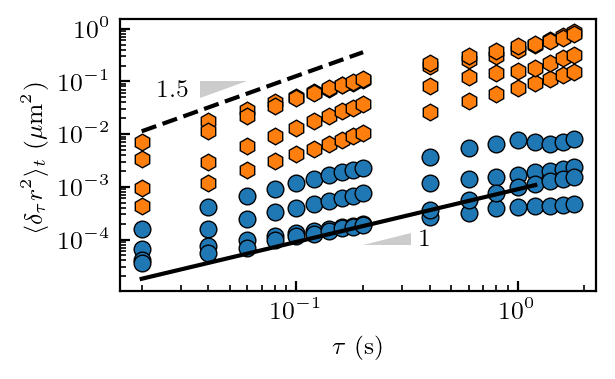

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))

for i, j in enumerate(exps):
    _, _, zz, rr, tt = pos[:,:,j].T
    if start_g[i] != None:
        ax.loglog(dtime, m2rs[:,i] * 1e12, ls='', marker='h', color='tab:orange')
    if start_nog[i] != None:
        ax.loglog(dtime, m2rs_nog[:,i] * 1e12, ls='', marker='o', mfc='tab:blue')

ax.plot(dtime[:15], 9e-4 * dtime[:15], ls='-', c='k')
ax.plot(dtime[:10], 4 * dtime[:10]**1.5, ls='--', c='k')

ax.set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r^2 \rangle_t$ ($\mathrm{\mu m^2}$)')

annotation.slope_marker((2e-1, 8e-5), 1, invert=False, ax=ax)
annotation.slope_marker((6e-2, 1e-1), 1.5, invert=True, ax=ax)

plt.tight_layout()
plt.show()

In [107]:
# fig.savefig('MSD_randomwalk.pdf')

# Analysis by Zooming on Signals

## Spot peaks of activity

In [108]:
# It works ok by using local variance (sliding variance) over N points. 
# But it works better by adapting what Allard did: smoothing, velocity and peaks. 

In [109]:
# Smoothing and local velocities
def _find_glidings_one_exp(d, t, threshold_v=0.3e-6, min_distance=10*fps, savgol_params=[201,2]):
    # d = x, y, z, r
    # Smooth
    d_filter = savgol_filter(d, *savgol_params)
    v_filter = np.diff(d_filter)/np.diff(t)
    # Absolute value
    v_filter = np.abs(v_filter)
    # Find gliding moments 
    tt = t[:-1]
    glidetest = np.zeros(len(tt)) # initialize
    # Look at the r trajectory
    glidetest[savgol_filter(v_filter[3],*savgol_params) >= threshold_v] = 1
    # find peaks
    indices = peakutils.indexes(glidetest, min_dist=min_distance)
    # clean peaks
    indices = indices[glidetest[indices] != 0]
    return indices

def get_data(j):
    traj = pos[:,:,j][~np.isnan(pos[:,:,j])]
    traj = traj.reshape(len(traj)//5,5)
    x, y, z, r, t = traj.T
    d = x, y, z, r
    return d, t

def find_glidings_one_exp(j, threshold_v=0.3e-6, min_distance=10*fps, savgol_params=[201,2]):
    d, t = get_data(j)
    indices = _find_glidings_one_exp(d, t, threshold_v=threshold_v, min_distance=min_distance, savgol_params=savgol_params)
    return d, t, indices

def find_glidings(exps, threshold_v=0.3e-6, min_distance=10*fps, savgol_params=[201,2]):
    res = []
    for i, j in enumerate(exps):
        _, _, indices = find_glidings_one_exp(j, threshold_v=threshold_v, min_distance=min_distance, savgol_params=savgol_params)
        res.append(indices)
    return res

### One signal

In [110]:
j = 0

In [111]:
d, t, indices = find_glidings_one_exp(j, threshold_v=0.3e-6, min_distance=5*fps)
indices

array([  572,  2598,  2943,  9070, 13041, 15376, 19945, 21959, 28017,
       31798, 33098, 39116, 41220, 42904])

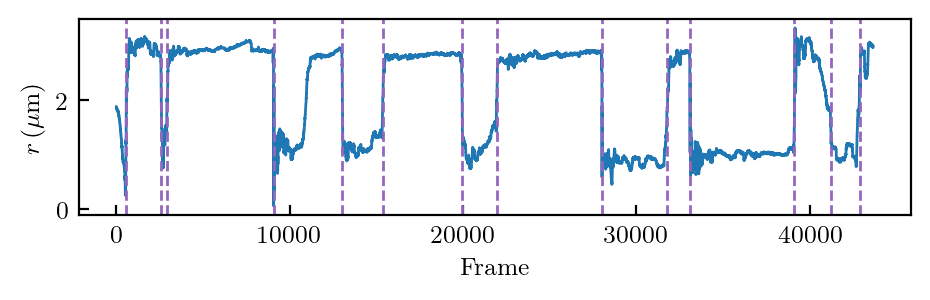

In [112]:
fig, ax1 = plt.subplots(1, 1, figsize=(12/2.54, 4/2.54))
ax1.plot(d[3] * 1e6, ls='-', c='tab:blue', lw=1)
ax1.set(xlabel=r'Frame', ylabel=r'$r \, \mathrm{(\mu m)}$')
for i, ind in enumerate(indices):
    ax1.axvline(x=ind, ls='--', lw=1, c='tab:purple')
plt.tight_layout()
plt.show()

### Every Signals

In [113]:
indices = find_glidings(np.arange(len(dirs)), min_distance=5*fps) # indices is now a list containing the arrays for all the experiments

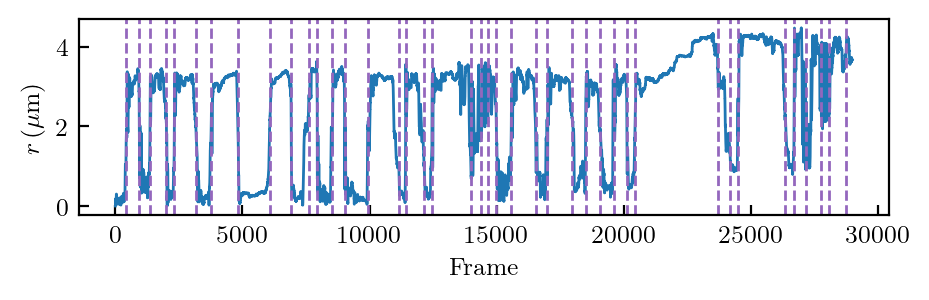

In [114]:
# Plot to check

j = 6
d, t = get_data(j)

fig, ax1 = plt.subplots(1, 1, figsize=(12/2.54, 4/2.54))
ax1.plot(d[3] * 1e6, ls='-', c='tab:blue', lw=1)
ax1.set(xlabel=r'Frame', ylabel=r'$r \, \mathrm{(\mu m)}$')
for i, ind in enumerate(indices[j]):
    ax1.axvline(x=ind, ls='--', lw=1, c='tab:purple')
plt.tight_layout()
plt.show()

In [115]:
# fig.savefig()

## Gliding Speed

In [116]:
def _compute_gliding_speed(rlocal, fps=50, params_savgol=[11,2]):
    r_temp_filter = savgol_filter(rlocal,*params_savgol)
    df = np.arange(1, 51, 1)
    dt = df / fps
    m_temp = moment(1, r_temp_filter,df)
    f = lambda x, a: a * x
    popt, _ = curve_fit(f, dt, m_temp)
    v = popt[0] 
    v = abs(v)
    return v

def compute_gliding_speed(j, indice, fps=50, dt=1, params_savgol=[11,2]):
    r = pos[:,3,j]
    r = r[~np.isnan(r)]
    indice = indices[j]
    v_gliding = np.ones(len(indice)) * np.nan
    for ii, idx in enumerate(indice):
        rr = r[(idx-dt*fps):(idx+dt*fps)]
        v_gliding[ii] = _compute_gliding_speed(rr, fps, params_savgol=params_savgol)
    return v_gliding

In [117]:
exps_gliding_speed = np.arange(len(dirs))

In [118]:
v_gliding = []
mean_v_gliding = np.zeros_like(exps_gliding_speed, dtype=float)
std_v_gliding = np.zeros_like(exps_gliding_speed, dtype=float)
for i, j in enumerate(exps_gliding_speed):
    v = compute_gliding_speed(j, indice=indices[j])
    v_gliding.append(v)
    mean_v_gliding[i] = np.nanmean(v)
    std_v_gliding[i] = np.nanstd(v)

/tmp/ipykernel_88751/259855727.py:7: RuntimeWarning: Mean of empty slice
  mean_v_gliding[i] = np.nanmean(v)
/home/n.fares/anaconda3/envs/chlamys/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


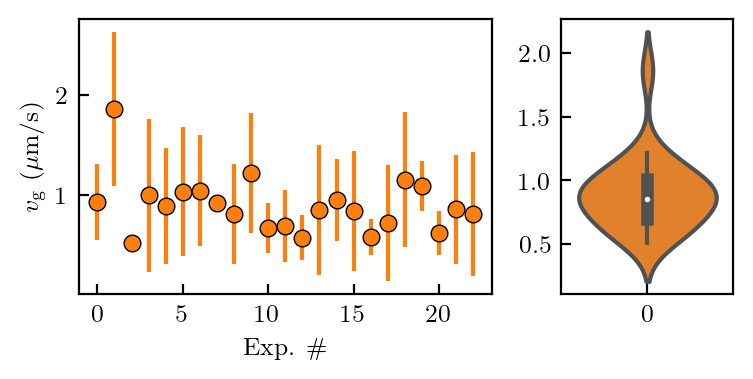

Number of gliding events = 343


In [119]:
fig = plt.figure(figsize=(10/2.54, 5/2.54))
ax1 = fig.add_subplot(1,3,(1,2))
ax1.errorbar(exps_gliding_speed, mean_v_gliding * 1e6, yerr=std_v_gliding*1e6, ls='', marker='o', c='tab:orange')
ax1.set(xlabel=r'Exp. \#', ylabel=r'$v_\mathrm{g}$ ($\mathrm{\mu m / s}$)')
ax2 = fig.add_subplot(1,3,3)
sns.violinplot(mean_v_gliding[~np.isnan(mean_v_gliding)]*1e6, color='tab:orange', ax=ax2)
plt.tight_layout()
plt.show()
print('Number of gliding events = {}'.format(np.sum(np.array([len(v_gliding[i]) for i in range(len(exps_gliding_speed))]))))

In [120]:
print(np.nanmean(mean_v_gliding))
# print(std_v_gliding)
print(np.nanmean(std_v_gliding))
print(np.nanstd(mean_v_gliding))

8.920079120001034e-07
4.592468780906925e-07
2.781061031107946e-07


## Local Properties Over One Gliding Events

In [121]:
# Show e.g. local MSD as a function of time. Give more details about the spikes of activity. 

# The goal is to average on all the experiments = same as for the MSDs at the beginning. 

### Auxiliary Functions

In [122]:
# Local moment
def local_moment(n, x, di=5, dj=2, retrieve_mean=True):
    return 1

# Local variance 
def local_variance(x, di=5, threshold=0.):
    res = np.zeros_like(x)
    for i in range(len(x)):
        if i < di:
            xx = x[:i+di]
        elif i >= len(x) - di:
            xx = x[i-di+1:]
        else:
            xx = x[i-di:i+di]
        temp = np.nanmean((xx - np.nanmean(xx)) ** 2)
        if temp > threshold: 
            res[i] = temp
    return res

In [123]:
# var_r = local_variance(r, di=10, threshold=1e-15)
# var_z = local_variance(z, di=5)

In [124]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

### Local Moments

In [125]:
def find_next_peak(r, i, indices):
    if i < len(indices) - 1:
        return indices[i+1]
    else:
        return len(r)-1

In [126]:
# # Full trajectory, one experiment

# # Choose a trajectory
# expj = 6

# # Get trajectory
# [x, y, z, r], t = get_data(expj)

# # Prepare figure 
# fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 5/2.54))
# axes[0].plot(t, r * 1e6, '-', c='tab:blue') # To plot gliding windows
# axes[1].plot(t, r * 1e6, '-', c='tab:blue') # To plot no-gliding windows


# ## Displacement 



# ### Parameters to select windows
# # Most of the work is here
# ### So BE CAREFUL
# dt = 1
# dtnog = int(6 * dt)
# # Times given in s 



# # Indexes of gliding
# indice = indices[expj]
# print(indices[expj])
# nb_glidings = len(indice)

# # Time steps to compute displacements, in frames
# df = np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, 10), np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)))
# # Initialize arrays to save data
# # Gliding 
# shape1 = len(indice)
# shape2 = len(df)
# shape3 = int(2 * dt * fps) - 1
# dr = np.ones((shape1, shape2, shape3), dtype=float) * np.nan # Displacement
# dz = np.ones((shape1, shape2, shape3), dtype=float) * np.nan
# vr = np.ones((shape1, shape2, shape3), dtype=float) * np.nan # Variance
# vz = np.ones((shape1, shape2, shape3), dtype=float) * np.nan
# print(np.shape(dr))
# # No gliding
# shape1nog = len(indice)
# shape2nog = len(df)
# shape3nog = max([(find_next_peak(r, i, indice)-dtnog*fps) - (indice[i]+dtnog*fps) for i in range(len(indice))])
# drnog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
# dznog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
# vrnog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
# vznog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
# print(np.shape(drnog))
# # Compute all displacements
# for i, idx in enumerate(indice):
#     ## Get one gliding
#     t_temp = t[(idx-dt*fps):(idx+dt*fps)]
#     r_temp = r[(idx-dt*fps):(idx+dt*fps)]
#     z_temp = z[(idx-dt*fps):(idx+dt*fps)]
#     # Plot
#     axes[0].plot(t_temp, r_temp * 1e6, '-', c='tab:red')
#     # Compute displacements and update dr
#     for j, f in enumerate(df):
#         dr_temp = r_temp[f:] - r_temp[:-f]
#         dr[i,j,:shape3+1-f] = np.copy(dr_temp)
#         dz_temp = z_temp[f:] - z_temp[:-f]
#         dz[i,j,:shape3+1-f] = np.copy(dz_temp)
#         vr[i,j,:shape3+1-f] = local_variance(dr_temp, di=f)
#         vz[i,j,:shape3+1-f] = local_variance(dz_temp, di=f)
#     ## Get one no gliding
#     # Index of the next gliding
#     idx2 = find_next_peak(r, i, indice)
#     t_temp = t[(idx+dtnog*fps):(idx2-dtnog*fps)]
#     r_temp = r[(idx+dtnog*fps):(idx2-dtnog*fps)]
#     z_temp = z[(idx+dtnog*fps):(idx2-dtnog*fps)]
#     # Plot 
#     axes[1].plot(t[idx], r[idx] * 1e6, 'x', mec='k')
#     axes[1].plot(t[idx+dtnog*fps], r[idx+dtnog*fps] * 1e6, 'x', mec='tab:orange')
#     axes[1].plot(t[idx2-dtnog*fps], r[idx2-dtnog*fps] * 1e6, 'x', mec='green')
#     axes[1].plot(t_temp, r_temp * 1e6, '-', c='tab:orange')
#     # Compute displacements and update dr
#     for j, f in enumerate(df):
#         dr_temp = r_temp[f:] - r_temp[:-f]
#         drnog[i,j,:len(dr_temp)] = np.copy(dr_temp)
#         dz_temp = z_temp[f:] - z_temp[:-f]
#         dznog[i,j,:len(dz_temp)] = np.copy(dz_temp)
#         vrnog[i,j,:len(dr_temp)] = local_variance(dr_temp, di=f)
#         vznog[i,j,:len(dz_temp)] = local_variance(dz_temp, di=f)

# # For now I lost the first no gliding (before indices[0])

# axes[0].set(xlabel=r'Time (s)', ylabel=r'$r$ ($\mathrm{\mu m}$)')
# axes[1].set(xlabel=r'Time (s)')
# plt.tight_layout()
# plt.show()

In [143]:
# Time steps to compute displacements, in frames
df = np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, 10), np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)))

def get_sorted_displacements(expj, dt=1, dtnog=6, df=df, plot=True):
    """
    Sort parts of one trajectory, in between moving and resting periods.
    For one single trajectory. 

    Important parameters: dt and dtnog
        The accuracy is mostly controled by these two parameters, as they set the sizes of the sliding windows.

    Inputs
    ------
    expj: int
        Experiment to choose
    dt, dtnog: int
        Size of the windows to consider for moving (dt) and resting (dtnog) periods.
        Actual size of the windows, in frames = int(2 * dt * fps) - 1
    df: numpy array
        Time steps to compute displacements, in frames

    Outputs
    -------
    dr, dz, vr, vz: numpy arrays 
        3D arrays, with shapes: # gliding events, # of points to compute displacements, size of the window
        d for displacements, v for variance
    drnog, dznog, vrnog, vznog: numpy arrays
        Same for no gliding periods
    """

    # Get trajectory
    [x, y, z, r], t = get_data(expj)

    # Prepare figure 
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 5/2.54))
        axes[0].plot(t, r * 1e6, '-', c='tab:blue') # To plot gliding windows
        axes[1].plot(t, r * 1e6, '-', c='tab:blue') # To plot no-gliding windows

    # Indexes of gliding
    indice = indices[expj]
    # print(indices[expj])
    nb_glidings = len(indice)

    # Initialize arrays to save data
    # Gliding 
    shape1 = len(indice)
    shape2 = len(df)
    shape3 = int(2 * dt * fps) - 1
    dr = np.ones((shape1, shape2, shape3), dtype=float) * np.nan # Displacement
    dz = np.ones((shape1, shape2, shape3), dtype=float) * np.nan
    vr = np.ones((shape1, shape2, shape3), dtype=float) * np.nan # Variance
    vz = np.ones((shape1, shape2, shape3), dtype=float) * np.nan
    # print(np.shape(dr))
    # No gliding
    shape1nog = len(indice)
    shape2nog = len(df)
    shape3nog = max([(find_next_peak(r, i, indice)-dtnog*fps) - (indice[i]+dtnog*fps) for i in range(len(indice))])
    drnog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
    dznog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
    vrnog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
    vznog = np.ones((shape1nog, shape2nog, shape3nog), dtype=float) * np.nan
    # print(np.shape(drnog))
    # Compute all displacements
    for i, idx in enumerate(indice):
        ## Get one gliding
        t_temp = t[(idx-dt*fps):(idx+dt*fps)]
        r_temp = r[(idx-dt*fps):(idx+dt*fps)]
        z_temp = z[(idx-dt*fps):(idx+dt*fps)]
        # Plot
        if plot:
            axes[0].plot(t_temp, r_temp * 1e6, '-', c='tab:red')
        # Compute displacements and update dr
        for j, f in enumerate(df):
            dr_temp = r_temp[f:] - r_temp[:-f]
            dr[i,j,:shape3+1-f] = np.copy(dr_temp)
            dz_temp = z_temp[f:] - z_temp[:-f]
            dz[i,j,:shape3+1-f] = np.copy(dz_temp)
            vr[i,j,:shape3+1-f] = local_variance(dr_temp, di=f)
            vz[i,j,:shape3+1-f] = local_variance(dz_temp, di=f)
        ## Get one no gliding
        # Index of the next gliding
        idx2 = find_next_peak(r, i, indice)
        t_temp = t[(idx+dtnog*fps):(idx2-dtnog*fps)]
        r_temp = r[(idx+dtnog*fps):(idx2-dtnog*fps)]
        z_temp = z[(idx+dtnog*fps):(idx2-dtnog*fps)]
        # Plot 
        if plot:
            axes[1].plot(t[idx], r[idx] * 1e6, 'x', mec='k')
            try:
                axes[1].plot(t[idx+dtnog*fps], r[idx+dtnog*fps] * 1e6, 'x', mec='tab:orange')
                axes[1].plot(t[idx2-dtnog*fps], r[idx2-dtnog*fps] * 1e6, 'x', mec='green')
            except:
                pass
            axes[1].plot(t_temp, r_temp * 1e6, '-', c='tab:orange')
        # Compute displacements and update dr
        for j, f in enumerate(df):
            dr_temp = r_temp[f:] - r_temp[:-f]
            drnog[i,j,:len(dr_temp)] = np.copy(dr_temp)
            dz_temp = z_temp[f:] - z_temp[:-f]
            dznog[i,j,:len(dz_temp)] = np.copy(dz_temp)
            vrnog[i,j,:len(dr_temp)] = local_variance(dr_temp, di=f)
            vznog[i,j,:len(dz_temp)] = local_variance(dz_temp, di=f)

    # For now I lost the first no gliding (before indices[0])

    if plot:
        axes[0].set(xlabel=r'Time (s)', ylabel=r'$r$ ($\mathrm{\mu m}$)')
        axes[1].set(xlabel=r'Time (s)')
        plt.tight_layout()
        plt.show()
    
    return dr, dz, vr, vz, drnog, dznog, vrnog, vznog

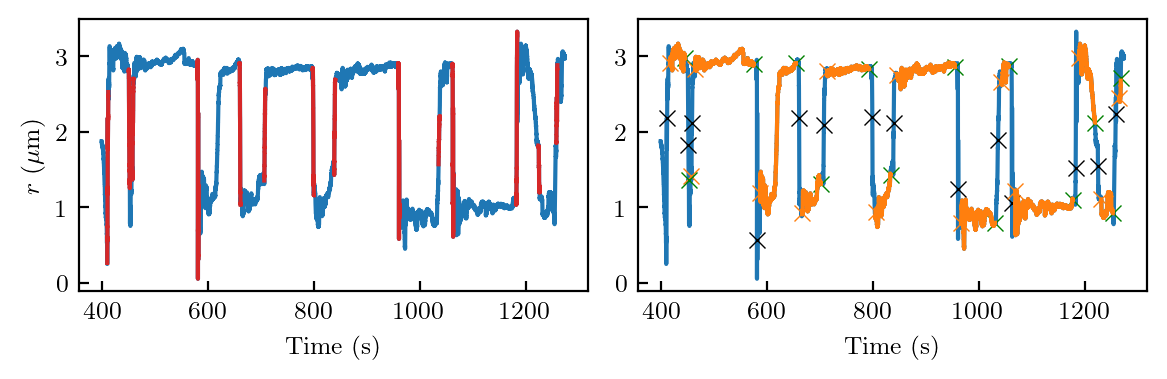

In [144]:
expj = 0

dr, dz, vr, vz, drnog, dznog, vrnog, vznog = get_sorted_displacements(expj, dt=1, dtnog=6, plot=True)


In [145]:
# Compute MSDs from a distribution
def distrib2msd(distrib):
    return np.nanmean((distrib - np.nanmean(distrib)) ** 2)

def correct_nans(array):
    return np.nan_to_num(array, nan=np.nanmean(array))

In [146]:
# # MSD for each gliding event
# m2r_all = np.ones((np.shape(dr)[0], np.shape(dr)[1], 1)) * np.nan
# # print(np.shape(m2r_all))
# m2z_all = np.ones((np.shape(dz)[0], np.shape(dz)[1], 1)) * np.nan
# # MSD for each no-gliding window
# m2rnog_all = np.ones((np.shape(drnog)[0], np.shape(drnog)[1], 1)) * np.nan
# # print(np.shape(m2rnog_all))
# m2znog_all = np.ones((np.shape(dznog)[0], np.shape(dznog)[1], 1)) * np.nan

# for i, idx in enumerate(indices):
#     for j, f in enumerate(df):
#         dr_temp = dr[i][j]
#         m2r_all[i][j] = distrib2msd(dr_temp) 
#         dr_temp = drnog[i][j]
#         m2rnog_all[i][j] = distrib2msd(dr_temp) 
#         dz_temp = dz[i][j]
#         m2z_all[i][j] = distrib2msd(dz_temp) 
#         dz_temp = dznog[i][j]
#         m2znog_all[i][j] = distrib2msd(dz_temp) 

# m2r_exp = np.ones((np.shape(m2r_all)[1])) * np.nan
# # print(np.shape(m2r_exp))
# m2rnog_exp = np.ones((np.shape(m2rnog_all)[1])) * np.nan
# # print(np.shape(m2rnog_exp))

# m2z_exp = np.ones((np.shape(m2z_all)[1])) * np.nan
# m2znog_exp = np.ones((np.shape(m2znog_all)[1])) * np.nan

# for j, f in enumerate(df):
#     m2r_exp[j] = np.nanmean(m2r_all[:,j])
#     m2rnog_exp[j] = np.nanmean(m2rnog_all[:,j])

# for j, f in enumerate(df):
#     m2z_exp[j] = np.nanmean(m2z_all[:,j])
#     m2znog_exp[j] = np.nanmean(m2znog_all[:,j])

# dtime = df / fps

In [147]:
def compute_local_MSD(expj, dr, dz, drnog, dznog):
    # MSD for each gliding event
    m2r_all = np.ones((np.shape(dr)[0], np.shape(dr)[1], 1)) * np.nan
    # print(np.shape(m2r_all))
    m2z_all = np.ones((np.shape(dz)[0], np.shape(dz)[1], 1)) * np.nan
    # MSD for each no-gliding window
    m2rnog_all = np.ones((np.shape(drnog)[0], np.shape(drnog)[1], 1)) * np.nan
    # print(np.shape(m2rnog_all))
    m2znog_all = np.ones((np.shape(dznog)[0], np.shape(dznog)[1], 1)) * np.nan

    for i, idx in enumerate(indices[expj]):
        for j, f in enumerate(df):
            dr_temp = dr[i][j]
            m2r_all[i][j] = distrib2msd(dr_temp) 
            dr_temp = drnog[i][j]
            m2rnog_all[i][j] = distrib2msd(dr_temp) 
            dz_temp = dz[i][j]
            m2z_all[i][j] = distrib2msd(dz_temp) 
            dz_temp = dznog[i][j]
            m2znog_all[i][j] = distrib2msd(dz_temp) 

    m2r_exp = np.ones((np.shape(m2r_all)[1])) * np.nan
    # print(np.shape(m2r_exp))
    m2rnog_exp = np.ones((np.shape(m2rnog_all)[1])) * np.nan
    # print(np.shape(m2rnog_exp))

    m2z_exp = np.ones((np.shape(m2z_all)[1])) * np.nan
    m2znog_exp = np.ones((np.shape(m2znog_all)[1])) * np.nan

    for j, f in enumerate(df):
        m2r_exp[j] = np.nanmean(m2r_all[:,j])
        m2rnog_exp[j] = np.nanmean(m2rnog_all[:,j])

    for j, f in enumerate(df):
        m2z_exp[j] = np.nanmean(m2z_all[:,j])
        m2znog_exp[j] = np.nanmean(m2znog_all[:,j])

    dtime = df / fps

    return m2r_exp, m2rnog_exp, m2r_all, m2rnog_all, m2z_exp, m2znog_exp, m2z_all, m2znog_all, dtime

In [148]:
m2r_exp, m2rnog_exp, m2r_all, m2rnog_all, m2z_exp, m2znog_exp, m2z_all, m2znog_all, dtime = compute_local_MSD(expj, dr, dz, drnog, dznog)

/tmp/ipykernel_88751/2950994654.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean((distrib - np.nanmean(distrib)) ** 2)
/tmp/ipykernel_88751/1335618445.py:31: RuntimeWarning: Mean of empty slice
  m2r_exp[j] = np.nanmean(m2r_all[:,j])
/tmp/ipykernel_88751/1335618445.py:32: RuntimeWarning: Mean of empty slice
  m2rnog_exp[j] = np.nanmean(m2rnog_all[:,j])
/tmp/ipykernel_88751/1335618445.py:35: RuntimeWarning: Mean of empty slice
  m2z_exp[j] = np.nanmean(m2z_all[:,j])
/tmp/ipykernel_88751/1335618445.py:36: RuntimeWarning: Mean of empty slice
  m2znog_exp[j] = np.nanmean(m2znog_all[:,j])


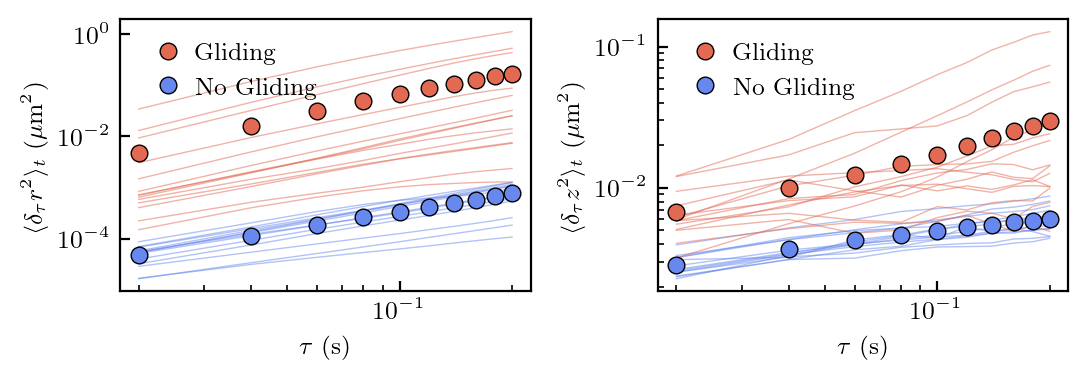

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(14/2.54, 5/2.54))

beg, end = 0, 10

for i in range(len(indices[expj])):
    axes[0].plot(dtime[beg:end], m2r_all[i,beg:end] * 1e12, ls='-', linewidth=0.5, c=palette[5], alpha=0.5)
    axes[0].plot(dtime[beg:end], m2rnog_all[i,beg:end] * 1e12, ls='-', linewidth=0.5, c=palette[0], alpha=0.5) #, label=str(i))
axes[0].plot(dtime[beg:end], m2r_exp[beg:end] * 1e12, 'o', c=palette[5], label='Gliding')
axes[0].plot(dtime[beg:end], m2rnog_exp[beg:end] * 1e12, 'o', c=palette[0], label='No Gliding')

for i in range(len(indices[expj])):
    axes[1].plot(dtime[beg:end], m2z_all[i,beg:end] * 1e12, ls='-', linewidth=0.5, c=palette[5], alpha=0.5)
    axes[1].plot(dtime[beg:end], m2znog_all[i,beg:end] * 1e12, ls='-', linewidth=0.5, c=palette[0], alpha=0.5) #, label=str(i))
axes[1].plot(dtime[beg:end], m2z_exp[beg:end] * 1e12, 'o', c=palette[5], label='Gliding')
axes[1].plot(dtime[beg:end], m2znog_exp[beg:end] * 1e12, 'o', c=palette[0], label='No Gliding')

axes[0].legend(frameon=False,handletextpad=0.1)
axes[1].legend(frameon=False,handletextpad=0.1)

axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')
axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau z ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')

plt.tight_layout()
plt.show()

/tmp/ipykernel_88751/855964926.py:5: RuntimeWarning: Mean of empty slice
  axes[0].plot(dtime[beg:end], np.nanmean(vrnog[i,beg:end,:], axis=1) * 1e12, ls='-', linewidth=0.5, c=palette[0])
/tmp/ipykernel_88751/855964926.py:7: RuntimeWarning: Mean of empty slice
  axes[1].plot(dtime[beg:end], np.nanmean(vznog[i,beg:end,:], axis=1) * 1e12, ls='-', linewidth=0.5, c=palette[0])


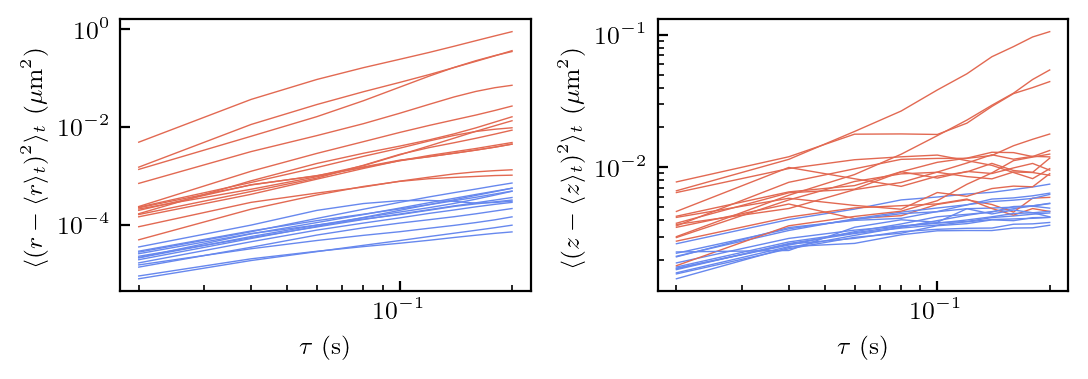

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(14/2.54, 5/2.54))

for i in range(len(indices[expj])):
    axes[0].plot(dtime[beg:end], np.nanmean(vr[i,beg:end,:], axis=1) * 1e12, ls='-', linewidth=0.5, c=palette[5])
    axes[0].plot(dtime[beg:end], np.nanmean(vrnog[i,beg:end,:], axis=1) * 1e12, ls='-', linewidth=0.5, c=palette[0])
    axes[1].plot(dtime[beg:end], np.nanmean(vz[i,beg:end,:], axis=1) * 1e12, ls='-', linewidth=0.5, c=palette[5])
    axes[1].plot(dtime[beg:end], np.nanmean(vznog[i,beg:end,:], axis=1) * 1e12, ls='-', linewidth=0.5, c=palette[0])

# axes[0].legend(frameon=False,handletextpad=0.1)
# axes[1].legend(frameon=False,handletextpad=0.1)

axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle (r - \langle r \rangle_t) ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')
axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle (z - \langle z \rangle_t) ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')

plt.tight_layout()
plt.show()

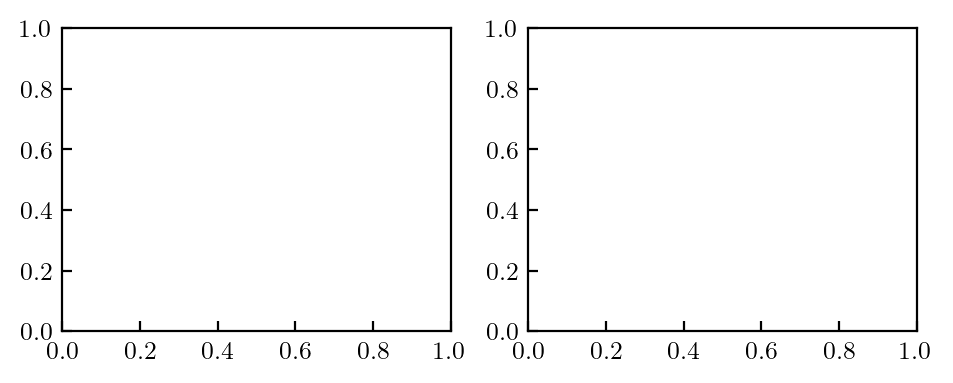

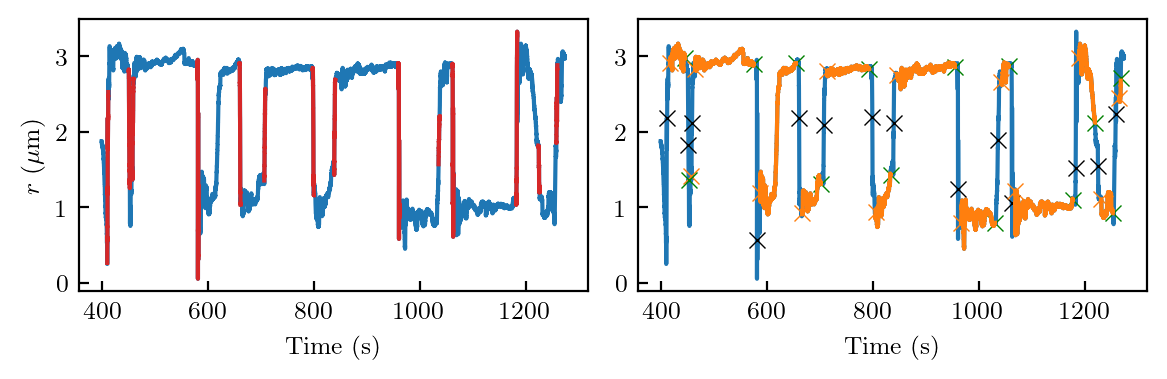

/tmp/ipykernel_88751/2950994654.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean((distrib - np.nanmean(distrib)) ** 2)
/tmp/ipykernel_88751/1335618445.py:31: RuntimeWarning: Mean of empty slice
  m2r_exp[j] = np.nanmean(m2r_all[:,j])
/tmp/ipykernel_88751/1335618445.py:32: RuntimeWarning: Mean of empty slice
  m2rnog_exp[j] = np.nanmean(m2rnog_all[:,j])
/tmp/ipykernel_88751/1335618445.py:35: RuntimeWarning: Mean of empty slice
  m2z_exp[j] = np.nanmean(m2z_all[:,j])
/tmp/ipykernel_88751/1335618445.py:36: RuntimeWarning: Mean of empty slice
  m2znog_exp[j] = np.nanmean(m2znog_all[:,j])


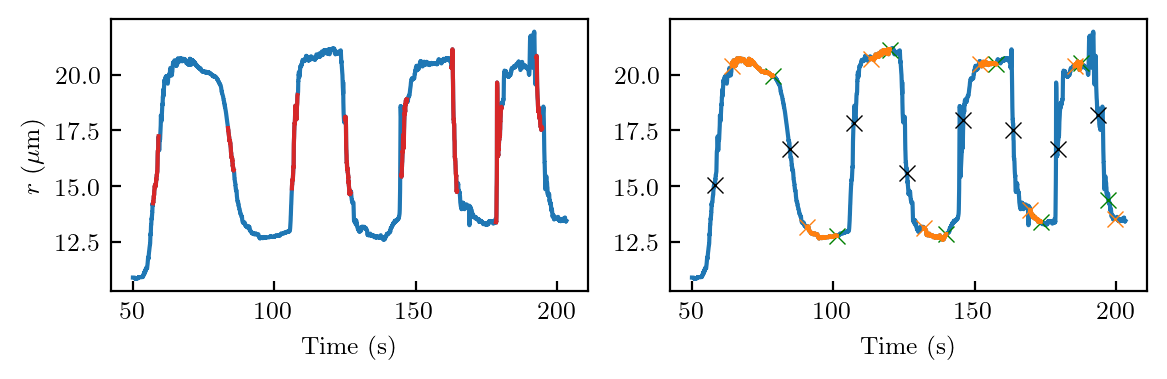

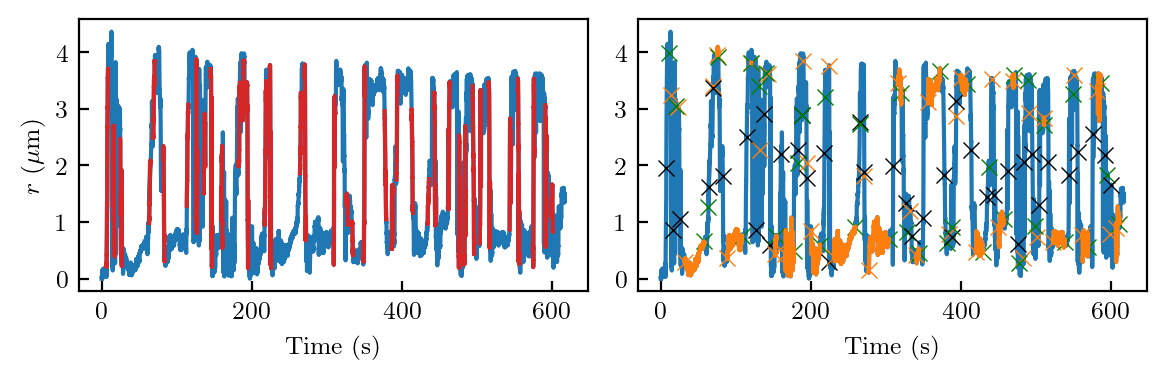

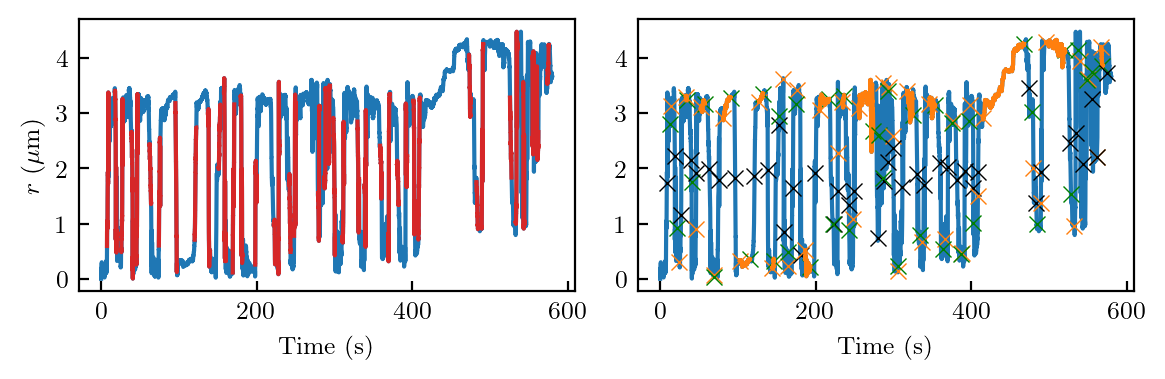

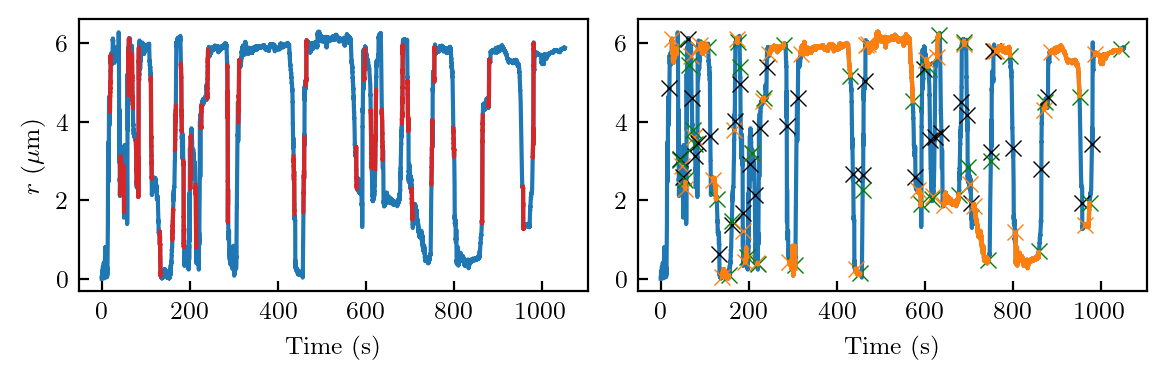

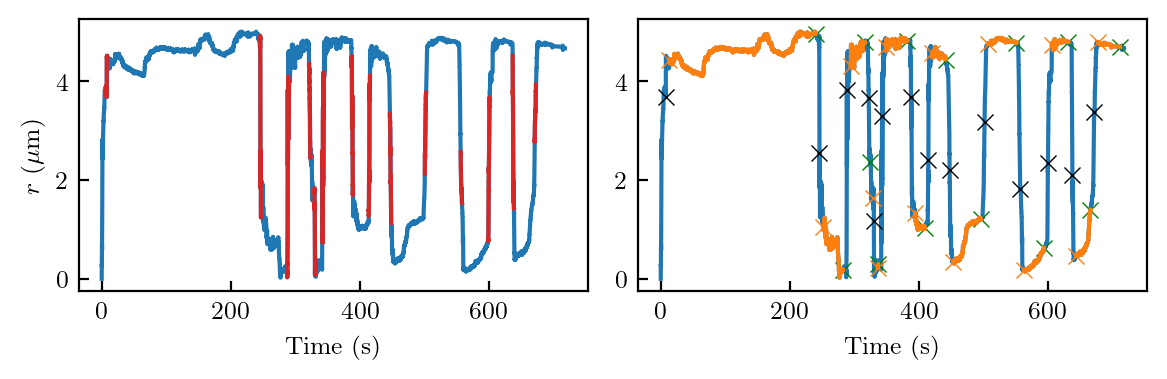

<Figure size 1280x960 with 0 Axes>

In [151]:
# Now all experiments

exps = tosave['exps_msd_2state']

m2r0 = []
m2r0nog = []
m2z0 = []
m2z0nog = []

ddd = [] # temp save, improve it to save it permanently

fig, axes = plt.subplots(1, 2, figsize=(14/2.54, 5/2.54))

for j, expj in enumerate(exps[:-1]):
    res = get_sorted_displacements(expj, dt=1, dtnog=6, plot=True)
    ddd.append(res)
    dr, dz, vr, vz, drnog, dznog, vrnog, vznog = res
    m2r_exp, m2rnog_exp, m2r_all, m2rnog_all, m2z_exp, m2znog_exp, m2z_all, m2znog_all, dtime = compute_local_MSD(expj, dr, dz, drnog, dznog)
    axes[0].plot(dtime[beg:end], m2r_exp[beg:end] * 1e12, '-', c=palette[5], linewidth=0.5, label='Gliding')
    axes[0].plot(dtime[beg:end], m2rnog_exp[beg:end] * 1e12, '-', c=palette[0], linewidth=0.5, label='No Gliding')
    axes[1].plot(dtime[beg:end], m2z_exp[beg:end] * 1e12, '-', c=palette[5], linewidth=0.5, label='Gliding')
    axes[1].plot(dtime[beg:end], m2znog_exp[beg:end] * 1e12, '-', c=palette[0], linewidth=0.5, label='No Gliding')
    for i in range(np.shape(m2r_all)[0]):
        m2r0.append(m2r_all[i][0].squeeze())
        m2r0nog.append(m2rnog_all[i][0].squeeze())
    for i in range(np.shape(m2rnog_all)[0]):
        m2z0.append(m2z_all[i][0].squeeze())
        m2z0nog.append(m2znog_all[i][0].squeeze())

# axes[0].legend(frameon=False,handletextpad=0.1)

axes[0].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau r ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')
axes[1].set(xlabel=r'$\tau$ (s)', ylabel=r'$\langle \delta_\tau z ^2 \rangle_t$ ($\mathrm{\mu m ^2}$)', xscale='log', yscale='log')

plt.tight_layout()
plt.show()

In [165]:
dfr = 0
dfz = dfr
dfrnog = dfr
dfznog = dfr

In [166]:
mobr = [] 
mobrnog = []
mobz = []
mobznog = []

for j, expj in enumerate(exps[:-1]): # exclude the experiment where the chlamys does not move
    dr, dz, vr, vz, drnog, dznog, vrnog, vznog = ddd[j]
    m2r_exp, m2rnog_exp, m2r_all, m2rnog_all, m2z_exp, m2znog_exp, m2z_all, m2znog_all, dtime = compute_local_MSD(expj, dr, dz, drnog, dznog)
    temp_r = m2r_all[:, dfr].squeeze()
    temp_rnog = m2rnog_all[:, dfrnog].squeeze()
    temp_z = m2z_all[:, dfz].squeeze()
    temp_znog = m2znog_all[:, dfznog].squeeze()
    mobr += list(temp_r)
    mobrnog += list(temp_rnog)
    mobz += list(temp_z)
    mobznog += list(temp_znog)

/tmp/ipykernel_88751/2950994654.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean((distrib - np.nanmean(distrib)) ** 2)
/tmp/ipykernel_88751/1335618445.py:31: RuntimeWarning: Mean of empty slice
  m2r_exp[j] = np.nanmean(m2r_all[:,j])
/tmp/ipykernel_88751/1335618445.py:32: RuntimeWarning: Mean of empty slice
  m2rnog_exp[j] = np.nanmean(m2rnog_all[:,j])
/tmp/ipykernel_88751/1335618445.py:35: RuntimeWarning: Mean of empty slice
  m2z_exp[j] = np.nanmean(m2z_all[:,j])
/tmp/ipykernel_88751/1335618445.py:36: RuntimeWarning: Mean of empty slice
  m2znog_exp[j] = np.nanmean(m2znog_all[:,j])


In [167]:
# mob0 = pd.DataFrame(data={'r': mobr, 'r-nog': mobrnog, 'z': mobz, 'z-nog': mobznog})
# fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))
# sns.boxplot(mob0[['r', 'r-nog']] * 1e12, palette=sns.color_palette('pastel'), fliersize=1, linewidth=1, ax=axes[0])
# axes[0].set(yscale='log', ylabel=r'$\langle \delta_1 r^2 \rangle \, \mathrm{(\mu m ^2)}$')
# sns.boxplot(mob0[['z', 'z-nog']] * 1e12, palette=sns.color_palette('pastel'), fliersize=1, linewidth=1, ax=axes[1])
# axes[1].set(yscale='log', ylabel=r'$\langle \delta_1 z^2 \rangle \, \mathrm{(\mu m ^2)}$')
# plt.tight_layout()
# plt.show()

In [168]:
def lists2pandas(Lr, Lrnog, Lz, Lznog, factor=1):
    # Get lists and correct for nans
    A = np.nan_to_num(Lrnog, nan=np.nanmean(Lrnog)) * factor # The order must be coherent with the rest of the code
    B = np.nan_to_num(Lznog, nan=np.nanmean(Lznog)) * factor
    C = np.nan_to_num(Lr) * factor
    D = np.nan_to_num(Lz) * factor
    E = list(A) + list(B) + list(C) + list(D)
    # Initialize pandas DataFrame, as a list for now
    res = [[0, '', ''] for i in range(len(E))]
    # Fill the first column
    for i, value in enumerate(E):
        res[i][0] = value
        # res[i][1] = 2 * kT / value
    # Fill the other columns 
    c = 0
    for i, k in enumerate(A):
        res[c+i][1] = 'r'
        res[c+i][2] = 'No'
    c += len(A)
    for i, k in enumerate(B):
        res[c+i][1] = 'z'
        res[c+i][2] = 'No'
    c += len(B)
    for i, k in enumerate(C):
        res[c+i][1] = 'r'
        res[c+i][2] = 'Yes'
    c += len(C)
    for i, k in enumerate(D):
        res[c+i][1] = 'z'
        res[c+i][2] = 'Yes'
    c += len(D)
    del A, B, C, D, E
    # Convert to pandas DataFrame
    res = pd.DataFrame(res, columns=['Value', 'Direction', 'Gliding'])
    return res

In [169]:
mob0 = lists2pandas(mobr, mobrnog, mobz, mobznog, factor=1e12)
# mob0 = lists2pandas(2*kT/np.array(mobr), 2*kT/np.array(mobrnog), 2*kT/np.array(mobz), 2*kT/np.array(mobznog), factor=1e6)

In [170]:
mob0.head()

,Value,Direction,Gliding
0,0.000057,r,No
1,0.000171,r,No
2,0.000016,r,No
3,0.000068,r,No
4,0.000040,r,No


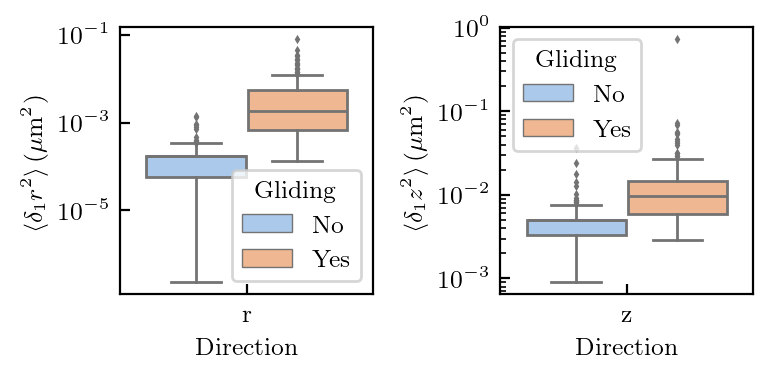

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))
sns.boxplot(data=mob0[mob0['Direction']=='r'], x='Direction', y='Value', hue='Gliding', palette=sns.color_palette('pastel'), fliersize=1, linewidth=1, ax=axes[0])
axes[0].set(yscale='log', ylabel=r'$\langle \delta_1 r^2 \rangle \, \mathrm{(\mu m ^2)}$')
sns.boxplot(data=mob0[mob0['Direction']=='z'], x='Direction', y='Value', hue='Gliding', palette=sns.color_palette('pastel'), fliersize=1, linewidth=1, ax=axes[1])
axes[1].set(yscale='log', ylabel=r'$\langle \delta_1 z^2 \rangle \, \mathrm{(\mu m ^2)}$')
plt.tight_layout()
plt.show()

In [172]:
# fig.savefig()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

z_No v.s. z_Yes: t-test independent samples with Bonferroni correction, P_val=1.461e-02 stat=-2.701e+00
r_No v.s. r_Yes: t-test independent samples with Bonferroni correction, P_val=5.640e-10 stat=-6.526e+00


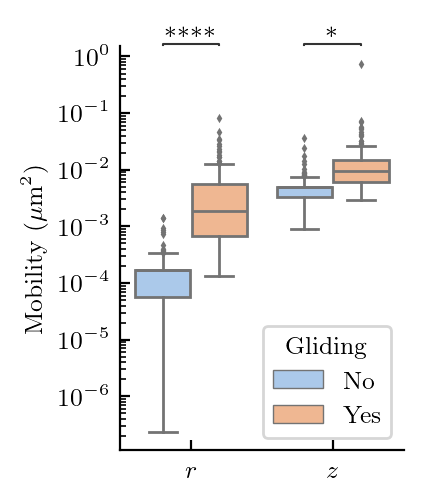

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54, 6/2.54))
sns.boxplot(mob0, x='Direction', y='Value', hue='Gliding', palette=sns.color_palette('pastel'), fliersize=1, linewidth=1, ax=ax)
ax.set(yscale='log', ylabel=r'Mobility $\mathrm{(\mu m ^2)}$', xlabel='', xticklabels=['$r$', '$z$'])
statannot.add_stat_annotation(
    ax,
    data=mob0,
    x='Direction',
    y='Value',
    hue='Gliding',
    box_pairs=[
        (("r", 'Yes'), ("r", "No")),
        (("z", "Yes"), ("z", "No")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
    linewidth=0.75, 
)
# Hide spine axis
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tight_layout(pad=0.2)
plt.show()

In [174]:
# fig.savefig('mobility_gliding_vs_nogliding.pdf')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

z_No v.s. z_Yes: t-test independent samples with Bonferroni correction, P_val=1.461e-02 stat=-2.701e+00
r_No v.s. r_Yes: t-test independent samples with Bonferroni correction, P_val=5.640e-10 stat=-6.526e+00


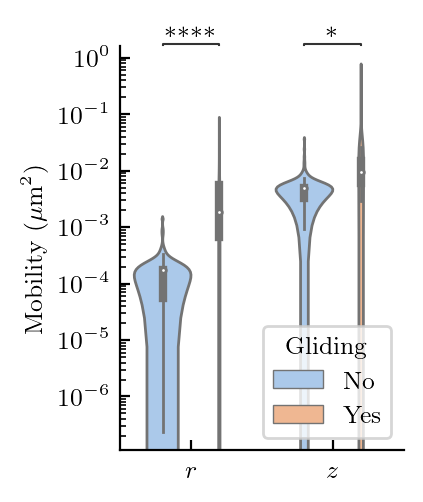

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54, 6/2.54))
sns.violinplot(mob0, x='Direction', y='Value', hue='Gliding', palette=sns.color_palette('pastel'), fliersize=1, linewidth=1, ax=ax)
ax.set(yscale='log', ylabel=r'Mobility $\mathrm{(\mu m ^2)}$', xlabel='', xticklabels=['$r$', '$z$'])
statannot.add_stat_annotation(
    ax,
    data=mob0,
    x='Direction',
    y='Value',
    hue='Gliding',
    box_pairs=[
        (("r", 'Yes'), ("r", "No")),
        (("z", "Yes"), ("z", "No")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
    linewidth=0.75, 
)
# Hide spine axis
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tight_layout(pad=0.2)
plt.show()

In [176]:
mob0.groupby(['Direction', 'Gliding'])['Value'].mean()

Direction  Gliding
r          No         0.000171
           Yes        0.005190
z          No         0.005022
           Yes        0.018094
Name: Value, dtype: float64

In [177]:
mob0.groupby(['Direction', 'Gliding'])['Value'].std()

Direction  Gliding
r          No         0.000200
           Yes        0.009511
z          No         0.003712
           Yes        0.059755
Name: Value, dtype: float64

In [178]:
mob0.groupby(['Direction', 'Gliding'])['Value'].size()

Direction  Gliding
r          No         153
           Yes        153
z          No         153
           Yes        153
Name: Value, dtype: int64

In [237]:
exps

array([ 0,  1,  5,  6,  8,  9, 23])

In [357]:
def derive(x, dt, n):
    res = np.ones_like(x) * np.nan
    # res[n:-n] = (x[int(2*n):] - x[:int(-2*n)]) / (t[int(2*n):] - t[:int(-2*n)])
    # res[:-n] = (x[n:] - x[:-n]) / (t[n:] - t[:-n])
    res[n:-n] = (x[int(2*n):] - x[:int(-2*n)]) / (2 * n * dt)
    return res

def velocity(x, dt, n):
    return derive(x, dt, n)

def acceleration(x, dt, n):
    res = np.ones_like(x) * np.nan
    res[n:-n] = (x[int(2*n):] - 2 * x[n:-n] + x[:-int(2*n)]) / (n * dt) ** 2
    return res

In [470]:
def measure_force(expj, direction='r', rho=1050, n1=1, n2=5, eta_m=0.0012):
    # Select one trajectory 
    x, y, z, r, t = pos[:,:,expj].T
    radius = radii[expj][0]
    if direction == 'r':
        s = np.copy(r)
    elif direction == 'z':
        s = np.copy(z)
    else: 
        s = np.copy(r)
        print('Wrong direction, r was chosen.')
    # Compute velocity and acceleration
    v = velocity(s, 1/fpss[expj], n1) # derive(s, 1/fpss[expj], n1)
    a = acceleration(s, 1/fpss[expj], n1) # derive(v, 1/fpss[expj], n1)
    # Mass estimate 
    m = rho * 4 / 3 * np.pi * radii[expj][0] ** 3
    # Drag estimate 
    # drag = 6 * np.pi * eta_m * radii[expj][0]
    # drag = 4 * np.pi * eta_m * radii[expj][0] / (np.log(2) - 1/2)
    drag = 6 * np.pi * eta_m * radius * (1 + 9/16 * (radius / (radius + 100e-9)))
    # Get force
    F = np.zeros_like(s) * np.nan
    for i in range(len(F)):
        # F[i] = np.nanmean(m * a[i-n2:i+n2])
        F[i] = np.nanmean(drag * v[i-n2:i+n2])
    # F = drag * v
    return s, F

In [476]:
expj = 6
r, Fr = measure_force(expj, direction='r', n1=1, n2=1)

/tmp/ipykernel_88751/2298090648.py:25: RuntimeWarning: Mean of empty slice
  F[i] = np.nanmean(drag * v[i-n2:i+n2])


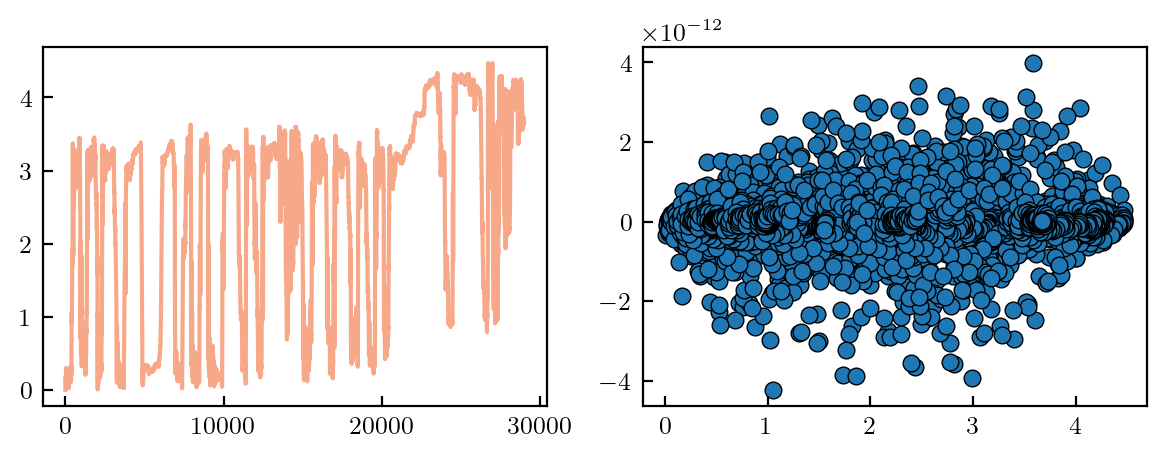

In [477]:
fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

axes[0].plot(r * 1e6, ls='-', c=palette[4])

axes[1].plot(r*1e6, Fr, 'o')
# axes[1].axvline(x=13, c='k')
# axes[1].axvline(x=22, c='k')

plt.tight_layout()
plt.show()

In [465]:
np.log(2)

np.float64(0.6931471805599453)

In [466]:
eta_m = 0.001
radius = 4e-6

drag = 6 * np.pi * eta_m * radius * (1 + 9/16 * (radius / (radius + 100e-9)))

F = drag * 1e-6
F

1.1677529766026448e-13